# Download Experiment Results from WandB

This notebook downloads probe performance results from WandB for different:
- Response generation policies (on-policy, prompted, incentivised, off-policy)
- Data domains (same-domain vs. different-domain)
- Behaviours
- Test conditions

Output: A structured CSV file with all probe performance metrics.


In [3]:
%%capture
import os
# If getting 'Could not find project LASR_probe_gen' get key from https://wandb.ai/authorize and paste below
os.environ["WANDB_SILENT"] = "true"
# os.environ["WANDB_API_KEY"] = ""
import wandb
wandb_token = os.getenv("WANDB_API_KEY")
wandb.login(key=wandb_token)

In [4]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

# Add project root to path
project_root = Path().absolute().parent / "src"
sys.path.insert(0, str(project_root))

from probe_gen.probes.wandb_interface import load_probe_eval_dicts_as_df
from probe_gen.standard_experiments.hyperparameter_search import get_best_hyperparams_for_train_setup
from probe_gen.config import BEHAVIOUR_DATASOURCE_ACTMODEL_OFFPOLICYMODEL, BEHAVIOUR_DATASOURCE_ACTMODEL_OFFPOLICYMODEL_DECEPTION


## Configuration


In [23]:
# Set experiment parameters
probe_type = "mean"  # Options: "mean", "attention_torch"
activations_model = ["llama_3b", "ministral_8b", "gemma_27b", "qwen_30b"][0]  # Currently the main option

# Choose whether to include deception experiments
include_deception = True

# Set test conditions
test_gen_methods = ['on_policy', 'incentivised']  # Test against both natural and incentivised

# Training generation methods to query
train_gen_methods = ['on_policy', 'incentivised', 'prompted', 'off_policy']


## Setup Experiment Configurations


In [24]:
# Combine experiment configurations
done_experiments = BEHAVIOUR_DATASOURCE_ACTMODEL_OFFPOLICYMODEL.copy()
if include_deception:
    done_experiments.update(BEHAVIOUR_DATASOURCE_ACTMODEL_OFFPOLICYMODEL_DECEPTION)

print(f"Behaviours to query: {list(done_experiments.keys())}")
print(f"Total behaviours: {len(done_experiments)}")


Behaviours to query: ['refusal', 'lists', 'metaphors', 'science', 'sycophancy', 'authority', 'deception', 'sandbagging']
Total behaviours: 8


## Function to Download Results


In [25]:
def download_probe_results(
    probe_type,
    behaviour,
    train_datasource,
    test_datasource,
    activations_model,
    train_gen_method,
    test_gen_method,
    train_response_model,
    test_response_model
):
    """
    Downloads probe results from WandB for a specific configuration.
    
    Returns:
        dict: Dictionary with AUROC and other metrics, or None if not found
    """
    # Get best hyperparameters for this configuration
    full_tr = [probe_type, behaviour, train_datasource, activations_model, 
               train_gen_method, train_response_model, "train"]
    
    try:
        cfg = get_best_hyperparams_for_train_setup([full_tr])[0][-1]
    except Exception as e:
        print(f"⚠ Could not get hyperparameters for {behaviour} - {train_gen_method}: {e}")
        return None
    
    # Build search dictionary for WandB query
    search_dict = {
        "config.probe/type": probe_type,
        "config.behaviour": behaviour,
        "config.train/datasource": train_datasource,
        "config.train/generation_method": train_gen_method,
        "config.train/response_model": train_response_model,
        "config.test/datasource": test_datasource,
        "config.test/generation_method": test_gen_method,
        "config.test/response_model": test_response_model,
        "config.layer": cfg.layer,
        "config.probe/use_bias": cfg.use_bias,
        "config.probe/normalize": cfg.normalize,
        "config.activations_model": activations_model,
        "state": "finished"
    }
    
    # Add probe-specific hyperparameters
    if probe_type == "mean":
        search_dict["config.probe/C"] = cfg.C
    elif "torch" in probe_type:
        search_dict["config.probe/lr"] = cfg.lr
        search_dict["config.probe/weight_decay"] = cfg.weight_decay
    
    # Query WandB
    try:
        run_df = load_probe_eval_dicts_as_df(search_dict)
        
        if len(run_df) == 0:
            return None
        
        # Return the last (most recent) result
        return {
            'roc_auc': run_df['metric_roc_auc'].iloc[-1],
            'accuracy': run_df.get('metric_accuracy', [None] * len(run_df)).iloc[-1],
            'tpr_at_1_fpr': run_df.get('metric_tpr_at_1_fpr', [None] * len(run_df)).iloc[-1],
        }
    except Exception as e:
        print(f"⚠ Error querying WandB for {behaviour} - {train_gen_method}: {e}")
        return None


## Download All Results


In [26]:
# Collect all results
all_results = []

# Iterate through all behaviours
for behaviour in tqdm(list(done_experiments.keys()), desc="Behaviours"):
    try:
        behaviour_config = done_experiments[behaviour]
        
        # Get the two datasources (ID and OOD)
        datasources = [ds for ds in behaviour_config.keys() if ds != "test_both"]
        print(f"{behaviour}:{datasources}")
        
        if len(datasources) < 2:
            print(f"⚠ Skipping {behaviour}: needs at least 2 datasources")
            continue
        
        id_datasource = datasources[0]
        ood_datasource = datasources[1]
        
        # Get off-policy models
        id_off_policy_model = behaviour_config[id_datasource][activations_model]
        ood_off_policy_model = behaviour_config[ood_datasource][activations_model]
        
        # Iterate through test conditions
        for test_gen_method in test_gen_methods:
            # Same-domain experiments (train and test on ID datasource)
            for train_gen_method in tqdm(train_gen_methods, desc=f"{behaviour} - Same-Domain", leave=False):
                train_response_model = id_off_policy_model if train_gen_method == "off_policy" else activations_model
                test_response_model = activations_model
                
                results = download_probe_results(
                    probe_type=probe_type,
                    behaviour=behaviour,
                    train_datasource=id_datasource,
                    test_datasource=id_datasource,
                    activations_model=activations_model,
                    train_gen_method=train_gen_method,
                    test_gen_method=test_gen_method,
                    train_response_model=train_response_model,
                    test_response_model=test_response_model
                )
                
                if results:
                    all_results.append({
                        'probe_type': probe_type,
                        'behaviour': behaviour,
                        'train_domain': 'same',
                        'train_datasource': id_datasource,
                        'test_datasource': id_datasource,
                        'train_generation_method': train_gen_method,
                        'test_generation_method': test_gen_method,
                        'activations_model': activations_model,
                        'train_response_model': train_response_model,
                        'test_response_model': test_response_model,
                        **results
                    })
            
            # Different-domain experiments (train on OOD, test on ID)
            for train_gen_method in tqdm(train_gen_methods, desc=f"{behaviour} - Diff-Domain", leave=False):
                train_response_model = ood_off_policy_model if train_gen_method == "off_policy" else activations_model
                test_response_model = activations_model
                
                results = download_probe_results(
                    probe_type=probe_type,
                    behaviour=behaviour,
                    train_datasource=ood_datasource,
                    test_datasource=id_datasource,
                    activations_model=activations_model,
                    train_gen_method=train_gen_method,
                    test_gen_method=test_gen_method,
                    train_response_model=train_response_model,
                    test_response_model=test_response_model
                )
                
                if results:
                    all_results.append({
                        'probe_type': probe_type,
                        'behaviour': behaviour,
                        'train_domain': 'different',
                        'train_datasource': ood_datasource,
                        'test_datasource': id_datasource,
                        'train_generation_method': train_gen_method,
                        'test_generation_method': test_gen_method,
                        'activations_model': activations_model,
                        'train_response_model': train_response_model,
                        'test_response_model': test_response_model,
                        **results
                    })
    
    except (KeyError, Exception) as e:
        print(f"⚠ Skipping {behaviour}: {type(e).__name__} - {str(e)}")
        continue

print(f"\n✓ Downloaded {len(all_results)} results")


Behaviours:   0%|          | 0/8 [00:00<?, ?it/s]

refusal:['rlhf', 'jailbreaks']


Behaviours:  12%|█▎        | 1/8 [00:29<03:27, 29.71s/it]

lists:['ultrachat', 'writingprompts']


Behaviours:  25%|██▌       | 2/8 [01:07<03:28, 34.70s/it]

metaphors:['ultrachat', 'writingprompts']


Behaviours:  38%|███▊      | 3/8 [01:42<02:53, 34.74s/it]

science:['ultrachat', 'mmlu']


Behaviours:  50%|█████     | 4/8 [02:16<02:16, 34.20s/it]

sycophancy:['multichoice', 'arguments', 'haikus']


Behaviours:  50%|█████     | 4/8 [02:31<02:31, 37.79s/it]


KeyboardInterrupt: 

In [ ]:
# Create DataFrame from results
results_df = pd.DataFrame(all_results)

# Reorder columns for better readability
column_order = [
    'probe_type',
    'behaviour',
    'train_domain',
    'train_generation_method',
    'test_generation_method',
    'train_datasource',
    'test_datasource',
    'activations_model',
    'train_response_model',
    'test_response_model',
    'roc_auc',
    'accuracy',
    'tpr_at_1_fpr'
]

results_df = results_df[column_order]

# Set 'lists' as the reference category for behaviour
results_df['behaviour'] = pd.Categorical(
    results_df['behaviour'],
    categories=['lists', 'authority', 'deception', 'metaphors', 'refusal', 'sandbagging', 'science', 'sycophancy'],
    ordered=False
)

# Display first few rows
print("\nFirst 10 rows:")
display(results_df.head(10))

print(results_df["behaviour"].unique())
print(f"\nDataFrame shape: {results_df.shape}")
print(f"Unique behaviours: {results_df['behaviour'].nunique()}")
print(f"Unique train generation methods: {results_df['train_generation_method'].unique()}")


First 10 rows:


,probe_type,behaviour,train_domain,train_generation_method,test_generation_method,train_datasource,test_datasource,activations_model,train_response_model,test_response_model,roc_auc,accuracy,tpr_at_1_fpr
0,mean,refusal,same,on_policy,on_policy,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.929744,0.724,0.606
1,mean,refusal,same,incentivised,on_policy,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.925464,0.704,0.600
2,mean,refusal,same,prompted,on_policy,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.897240,0.656,0.494
3,mean,refusal,same,off_policy,on_policy,rlhf,rlhf,qwen_30b,ministral_8b,qwen_30b,0.927480,0.766,0.602
4,mean,refusal,different,on_policy,on_policy,jailbreaks,rlhf,qwen_30b,qwen_30b,qwen_30b,0.870272,0.803,0.300
5,mean,refusal,different,incentivised,on_policy,jailbreaks,rlhf,qwen_30b,qwen_30b,qwen_30b,0.869944,0.804,0.356
6,mean,refusal,different,prompted,on_policy,jailbreaks,rlhf,qwen_30b,qwen_30b,qwen_30b,0.872916,0.751,0.318
7,mean,refusal,different,off_policy,on_policy,jailbreaks,rlhf,qwen_30b,ministral_8b,qwen_30b,0.614384,0.582,0.012
8,mean,refusal,same,on_policy,incentivised,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.869224,0.583,0.084
9,mean,refusal,same,incentivised,incentivised,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.904484,0.673,0.446


['refusal', 'metaphors', 'science']
Categories (8, object): ['lists', 'authority', 'deception', 'metaphors', 'refusal', 'sandbagging', 'science', 'sycophancy']

DataFrame shape: (48, 13)
Unique behaviours: 3
Unique train generation methods: ['on_policy' 'incentivised' 'prompted' 'off_policy']


In [ ]:
results_test_on_policy = results_df[(results_df['test_generation_method'] == 'on_policy') & (results_df['behaviour'] != 'deception') & (results_df['behaviour'] != 'sandbagging')]

results_test_on_policy

,probe_type,behaviour,train_domain,train_generation_method,test_generation_method,train_datasource,test_datasource,activations_model,train_response_model,test_response_model,roc_auc,accuracy,tpr_at_1_fpr
0,mean,refusal,same,on_policy,on_policy,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.929744,0.724,0.606
1,mean,refusal,same,incentivised,on_policy,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.925464,0.704,0.600
2,mean,refusal,same,prompted,on_policy,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.897240,0.656,0.494
3,mean,refusal,same,off_policy,on_policy,rlhf,rlhf,qwen_30b,ministral_8b,qwen_30b,0.927480,0.766,0.602
4,mean,refusal,different,on_policy,on_policy,jailbreaks,rlhf,qwen_30b,qwen_30b,qwen_30b,0.870272,0.803,0.300
5,mean,refusal,different,incentivised,on_policy,jailbreaks,rlhf,qwen_30b,qwen_30b,qwen_30b,0.869944,0.804,0.356
6,mean,refusal,different,prompted,on_policy,jailbreaks,rlhf,qwen_30b,qwen_30b,qwen_30b,0.872916,0.751,0.318
7,mean,refusal,different,off_policy,on_policy,jailbreaks,rlhf,qwen_30b,ministral_8b,qwen_30b,0.614384,0.582,0.012
16,mean,metaphors,same,on_policy,on_policy,ultrachat,ultrachat,qwen_30b,qwen_30b,qwen_30b,0.905392,0.818,0.510
17,mean,metaphors,same,incentivised,on_policy,ultrachat,ultrachat,qwen_30b,qwen_30b,qwen_30b,0.896404,0.760,0.456


In [ ]:
results_test_incentivised = results_df[(results_df['test_generation_method'] == 'incentivised') & (results_df['train_generation_method'] != 'on_policy')]


results_test_incentivised

,probe_type,behaviour,train_domain,train_generation_method,test_generation_method,train_datasource,test_datasource,activations_model,train_response_model,test_response_model,roc_auc,accuracy,tpr_at_1_fpr
9,mean,refusal,same,incentivised,incentivised,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.904484,0.673,0.446
10,mean,refusal,same,prompted,incentivised,rlhf,rlhf,qwen_30b,qwen_30b,qwen_30b,0.850892,0.522,0.334
11,mean,refusal,same,off_policy,incentivised,rlhf,rlhf,qwen_30b,ministral_8b,qwen_30b,0.850628,0.633,0.128
13,mean,refusal,different,incentivised,incentivised,jailbreaks,rlhf,qwen_30b,qwen_30b,qwen_30b,0.822144,0.682,0.062
14,mean,refusal,different,prompted,incentivised,jailbreaks,rlhf,qwen_30b,qwen_30b,qwen_30b,0.789276,0.696,0.142
15,mean,refusal,different,off_policy,incentivised,jailbreaks,rlhf,qwen_30b,ministral_8b,qwen_30b,0.654236,0.606,0.016
25,mean,metaphors,same,incentivised,incentivised,ultrachat,ultrachat,qwen_30b,qwen_30b,qwen_30b,0.985128,0.939,0.880
26,mean,metaphors,same,prompted,incentivised,ultrachat,ultrachat,qwen_30b,qwen_30b,qwen_30b,0.972140,0.920,0.746
27,mean,metaphors,same,off_policy,incentivised,ultrachat,ultrachat,qwen_30b,ministral_8b,qwen_30b,0.936040,0.859,0.458
29,mean,metaphors,different,incentivised,incentivised,writingprompts,ultrachat,qwen_30b,qwen_30b,qwen_30b,0.968408,0.926,0.796


# Mixed Model 

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd


def plot_mixed_model_overall_effects(results_df, model_result=None,
                                     figsize=(18, 20), save_path=None):
    """
    Create visualization of overall domain and generation method effects
    for mixed effects model: roc_auc ~ generation_method * train_domain, groups=behaviour
    
    This shows the AVERAGE effects across all behaviours (fixed effects only).
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with columns: 'behaviour', 'train_domain', 'generation_method', 'roc_auc'
    model_result : statsmodels MixedLMResults, optional
        The fitted mixed model to extract significance from
    figsize : tuple
        Figure size (width, height)
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig, (ax1, ax2) : matplotlib figure and axes
    """
    
    # Determine which generation methods are available
    preferred_order = ['on_policy', 'incentivised', 'prompted', 'off_policy']
    methods_in_data = set(results_df['generation_method'].unique())
    available_methods = [m for m in preferred_order if m in methods_in_data]
    
    # Extract p-values from model if provided
    if model_result is not None:
        pvalues = model_result.pvalues
        
        # Domain effect p-value
        domain_pval = pvalues.get('train_domain[T.different]', 1.0)
        
        # Generation method p-values
        reference_method = results_df['generation_method'].cat.categories[0]
        method_pvals = {}
        for method in available_methods:
            if method == reference_method:
                method_pvals[method] = 'ref'
            else:
                key = f'generation_method[T.{method}]'
                method_pvals[method] = pvalues.get(key, 1.0)
        
        # Interaction p-values (generation_method:domain)
        interaction_pvals = {}
        for method in available_methods:
            if method == reference_method:
                interaction_pvals[method] = 'ref'
            else:
                key = f'generation_method[T.{method}]:train_domain[T.different]'
                interaction_pvals[method] = pvalues.get(key, 1.0)
    else:
        domain_pval = 1.0
        method_pvals = {method: 1.0 for method in available_methods}
        interaction_pvals = {method: 1.0 for method in available_methods}
    
    # Create figure with vertical layout matching the original
    fig = plt.figure(figsize=figsize)
    
    # Create GridSpec for custom layout: plots on left, legends on right, with middle space
    gs = fig.add_gridspec(3, 2, width_ratios=[2.5, 1], height_ratios=[1, 0.3, 1],
                         hspace=0.15, wspace=0.2, left=0.1, right=0.98, 
                         top=0.95, bottom=0.05)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[2, 0])
    
    # ===== TOP PANEL: Domain effect (averaged across all behaviours) =====
    # Calculate overall means across all behaviours
    domain_means = results_df.groupby('train_domain')['roc_auc'].mean()
    same_val = domain_means.loc['same']
    diff_val = domain_means.loc['different']
    penalty = same_val - diff_val
    
    # Determine significance styling
    is_significant = domain_pval < 0.05
    linestyle = '-' if is_significant else '--'
    alpha = 0.8 if is_significant else 0.4
    linewidth = 5 if is_significant else 3
    
    # Plot domain effect
    ax1.plot([0, 1], [same_val, diff_val], 
             linestyle=linestyle, linewidth=linewidth, 
             marker='o', markersize=18, color='#2c3e50', 
             alpha=alpha, solid_capstyle='round')
    
    ax1.set_xlim([-0.1, 1.1])
    ax1.set_ylim([0.4, 1.0])
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Same Domain', 'Different Domain'], fontsize=28, fontweight='bold')
    ax1.set_ylabel('ROC-AUC Performance', fontsize=30, fontweight='bold', labelpad=15)
    ax1.set_title('A) Average Effects of Domain', fontsize=32, fontweight='bold', pad=25)
    ax1.tick_params(axis='y', labelsize=24)
    ax1.grid(axis='y', alpha=0.2, linestyle=':', linewidth=1.5)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    # Create legend for domain panel
    sig_marker = '***' if domain_pval < 0.001 else '**' if domain_pval < 0.01 else '*' if domain_pval < 0.05 else 'ns'
    legend_elements_domain = [
        Line2D([0], [0], color='#2c3e50', linewidth=5, linestyle='-', alpha=0.8,
               label=f'Overall: Δ={penalty:.3f} {sig_marker}')
    ]
    
    # Place legend on the right side for domain panel
    ax1_legend = fig.add_subplot(gs[0, 1])
    ax1_legend.axis('off')
    legend1 = ax1_legend.legend(handles=legend_elements_domain, loc='lower left', 
                               fontsize=26, framealpha=0.95, edgecolor='gray', 
                               title='Domain Penalty', title_fontsize=26,
                               bbox_to_anchor=(0.0, 0.0))
    
    # ===== BOTTOM PANEL: Generation method effect =====
    # Calculate overall means across all behaviours
    method_means = results_df.groupby('generation_method')['roc_auc'].mean()
    
    values = [method_means.loc[method] for method in available_methods]
    method_range = max(values) - min(values)
    
    x_positions = list(range(len(available_methods)))
    
    # Plot generation method effect
    # Draw segments with appropriate styling based on significance
    for i in range(len(x_positions) - 1):
        x_start, x_end = x_positions[i], x_positions[i + 1]
        y_start, y_end = values[i], values[i + 1]
        
        # Check significance of the target (end) method
        method_end = available_methods[i + 1]
        p_val = method_pvals.get(method_end, 1.0)
        is_significant = (p_val != 'ref' and p_val < 0.05)
        
        linestyle = '-' if is_significant else '--'
        alpha = 0.8 if is_significant else 0.4
        linewidth = 5 if is_significant else 3
        
        # Draw segment
        ax2.plot([x_start, x_end], [y_start, y_end], 
                linestyle=linestyle, linewidth=linewidth,
                color='#2c3e50', alpha=alpha, solid_capstyle='round')
    
    # Draw all points on top
    ax2.plot(x_positions, values, marker='o', markersize=14, 
            color='#2c3e50', alpha=0.8, linestyle='', zorder=10)
    
    ax2.set_xlim([-0.3, len(available_methods) - 0.7])
    ax2.set_ylim([0.4, 1.0])
    ax2.set_xticks(x_positions)
    
    # Format method names for display
    method_labels = [m.replace('_', '-').title() for m in available_methods]
    ax2.set_xticklabels(method_labels,
                        fontsize=26, fontweight='bold', rotation=20, ha='right')
    ax2.set_ylabel('ROC-AUC Performance', fontsize=30, fontweight='bold', labelpad=15)
    ax2.set_title('B) Average Effects of Generation Method', fontsize=32, fontweight='bold', pad=25)
    ax2.tick_params(axis='y', labelsize=24)
    ax2.grid(axis='y', alpha=0.2, linestyle=':', linewidth=1.5)
    ax2.grid(axis='x', alpha=0.1, linestyle=':', linewidth=1.5)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    # Format p-values as significance markers
    def format_pval(p):
        if p == 'ref':
            return 'ref'
        elif p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'
    
    pval_list = [format_pval(method_pvals.get(method, 1.0)) for method in available_methods]
    method_abbrev = [m[:3].capitalize() for m in available_methods]
    legend_suffix = f"[{', '.join(method_abbrev)}]"
    
    # Create legend for generation method panel
    pval_str = f"[{', '.join(pval_list)}]"
    legend_elements_method = [
        Line2D([0], [0], color='#2c3e50', linewidth=5, linestyle='-', alpha=0.8,
               label=f'Overall: Δ={method_range:.3f} {pval_str}')
    ]
    
    # Place legend on the right side for generation method panel
    ax2_legend = fig.add_subplot(gs[2, 1])
    ax2_legend.axis('off')
    legend2 = ax2_legend.legend(handles=legend_elements_method, loc='lower left',
                               fontsize=26, framealpha=0.95, edgecolor='gray',
                               title=f'Method Range {legend_suffix}', 
                               title_fontsize=26,
                               bbox_to_anchor=(0.0, 0.0))
    
    # ===== SHARED MIDDLE LEGEND: Line style significance =====
    ax_middle = fig.add_subplot(gs[1, 1])
    ax_middle.axis('off')
    
    # Add styling legend (solid vs dashed)
    style_elements = [
        Line2D([0], [0], color='gray', linewidth=5, linestyle='-', alpha=0.8, label='Significant\n(p < 0.05)'),
        Line2D([0], [0], color='gray', linewidth=3, linestyle='--', alpha=0.4, label='Not significant')
    ]
    
    legend_style = ax_middle.legend(handles=style_elements, loc='center left', 
                     fontsize=24, framealpha=0.95, edgecolor='gray',
                     title='Line Style', title_fontsize=24,
                     bbox_to_anchor=(0.0, 0.5))
    
    # Add significance annotation
    ax_middle.text(1, 0.5, '*** p < 0.001\n** p < 0.01\n* p < 0.05\nns = not sig.\nref = reference', 
                   fontsize=24, verticalalignment='center', horizontalalignment='left',
                   bbox=dict(boxstyle='round,rounding_size=0.25', facecolor='white', 
                   alpha=0.9, edgecolor='gray', pad=0.8),
                   transform=ax_middle.transAxes)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig, (ax1, ax2)


def plot_mixed_model_by_domain(results_df, model_result=None,
                                figsize=(12, 6), save_path=None):
    """
    Alternative visualization showing generation method effect SEPARATELY for each domain
    to visualize the interaction term.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with columns: 'behaviour', 'train_domain', 'generation_method', 'roc_auc'
    model_result : statsmodels MixedLMResults, optional
        The fitted mixed model to extract significance from
    figsize : tuple
        Figure size (width, height)
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    # Determine which generation methods are available
    preferred_order = ['on_policy', 'incentivised', 'prompted', 'off_policy']
    methods_in_data = set(results_df['generation_method'].unique())
    available_methods = [m for m in preferred_order if m in methods_in_data]
    
    # Extract p-values from model if provided
    if model_result is not None:
        pvalues = model_result.pvalues
        
        # Interaction p-values
        reference_method = results_df['generation_method'].cat.categories[0]
        interaction_pvals = {}
        for method in available_methods:
            if method == reference_method:
                interaction_pvals[method] = 'ref'
            else:
                key = f'generation_method[T.{method}]:train_domain[T.different]'
                interaction_pvals[method] = pvalues.get(key, 1.0)
    else:
        interaction_pvals = {method: 1.0 for method in available_methods}
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot for each domain
    colors = {'same': '#3498db', 'different': '#e74c3c'}
    markers = {'same': 'o', 'different': 's'}
    
    for domain in ['same', 'different']:
        domain_data = results_df[results_df['train_domain'] == domain]
        method_means = domain_data.groupby('generation_method')['roc_auc'].mean()
        method_se = domain_data.groupby('generation_method')['roc_auc'].sem()
        
        values = [method_means.loc[method] for method in available_methods]
        se_values = [method_se.loc[method] for method in available_methods]
        
        x_positions = list(range(len(available_methods)))
        
        # Plot line and points
        ax.plot(x_positions, values, 
                marker=markers[domain], markersize=14, 
                linewidth=4, color=colors[domain], 
                alpha=0.8, label=f'{domain.title()} Domain',
                solid_capstyle='round')
        
        # Add error bars
        ax.errorbar(x_positions, values, yerr=se_values,
                   fmt='none', ecolor=colors[domain], 
                   elinewidth=2, capsize=6, alpha=0.5)
    
    ax.set_xlim([-0.3, len(available_methods) - 0.7])
    ax.set_ylim([0.5, 1.0])
    ax.set_xticks(x_positions)
    
    # Format method names for display
    method_labels = [m.replace('_', '-').title() for m in available_methods]
    ax.set_xticklabels(method_labels,
                       fontsize=20, fontweight='bold', rotation=25, ha='right')
    ax.set_ylabel('ROC-AUC Performance', fontsize=24, fontweight='bold', labelpad=10)
    ax.set_title('Generation Method × Domain Interaction\n(Average Across Behaviours)', 
                 fontsize=24, fontweight='bold', pad=20)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid(axis='y', alpha=0.3, linestyle=':', linewidth=1.5)
    ax.grid(axis='x', alpha=0.1, linestyle=':', linewidth=1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    ax.legend(fontsize=18, loc='best', framealpha=0.95, edgecolor='gray')
    
    # Add interaction significance annotation
    def format_pval(p):
        if p == 'ref':
            return 'ref'
        elif p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'
    
    interaction_list = [format_pval(interaction_pvals.get(method, 1.0)) for method in available_methods]
    method_abbrev = [m[:3].upper() for m in available_methods]
    interaction_str = ' | '.join([f'{abbr}: {pval}' for abbr, pval in zip(method_abbrev, interaction_list)])
    
    ax.text(0.5, 0.05, f'Interaction p-values: {interaction_str}', 
            transform=ax.transAxes, fontsize=16, 
            ha='center', va='bottom', style='italic',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig, ax

In [29]:
def create_regression_latex_table(result, round_coef=3, round_se=3, round_pval=4):
    """
    Create a formatted LaTeX table from regression results with highlighted significant rows.
    
    Parameters:
    -----------
    result : statsmodels results object
        The fitted model results (e.g., from mixedlm, OLS, etc.)
    round_coef : int, default=3
        Number of decimal places for coefficients
    round_se : int, default=3
        Number of decimal places for standard errors
    round_pval : int, default=4
        Number of decimal places for p-values
    
    Returns:
    --------
    str : LaTeX table string with highlighted significant rows
    """
    import pandas as pd
    
    # Create summary dataframe with coefficients, SE, and p-values
    summary_df = pd.DataFrame({
        'Coefficient': result.params.round(round_coef),
        'Std. Error': result.bse.round(round_se),
        'p-value': result.pvalues.round(round_pval)
    })
    
    # Add significance markers
    summary_df['Sig.'] = summary_df['p-value'].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    )
    
    # Store which rows are significant for highlighting
    significant_rows = summary_df['p-value'] < 0.05
    
    # Store original variable names before LaTeX escaping for matching
    original_var_names = list(summary_df.index)
    
    # Clean up index names for LaTeX
    summary_df.index = summary_df.index.str.replace('_', '\\_')
    summary_df.index = summary_df.index.str.replace('[', '{[}')
    summary_df.index = summary_df.index.str.replace(']', '{]}')
    summary_df.index = summary_df.index.str.replace(':', '{:}')
    
    # Get number of groups (if available)
    try:
        n_groups = result.model.n_groups
        group_row = f'N groups: {n_groups}'
    except AttributeError:
        group_row = None
    
    # Create fit statistics rows
    fit_indices = ['\\midrule', f'N observations: {int(result.nobs)}']
    fit_values = [['', '', '', ''], ['', '', '', '']]
    
    if group_row:
        fit_indices.append(group_row)
        fit_values.append(['', '', '', ''])
    
    fit_indices.append(f'Log-Likelihood: {result.llf:.2f}')
    fit_values.append(['', '', '', ''])
    
    fit_stats = pd.DataFrame(
        fit_values,
        columns=['Coefficient', 'Std. Error', 'p-value', 'Sig.'],
        index=fit_indices
    )
    
    # Combine coefficient results with fit statistics
    summary_with_stats = pd.concat([summary_df, fit_stats])
    
    # Convert to LaTeX
    latex_table = summary_with_stats.to_latex(escape=False)
    
    # Add row highlighting for significant results
    lines = latex_table.split('\n')
    
    highlighted_lines = []
    
    for i, line in enumerate(lines):
        # Add color package requirement as a comment at the beginning
        if i == 0:
            highlighted_lines.append('% Requires: \\usepackage[table]{xcolor} in preamble')
        
        # Check if this line contains a coefficient row by looking for the variable names
        # Look for lines that start with a variable name and contain data
        is_data_row = False
        row_index = -1
        
        for j, var_name in enumerate(summary_df.index[:len(significant_rows)]):
            # Check if this line starts with this variable name
            if line.strip().startswith(var_name + ' &'):
                is_data_row = True
                row_index = j
                break
        
        # If this is a significant data row, add highlighting before it
        if is_data_row and row_index >= 0 and significant_rows.iloc[row_index]:
            highlighted_lines.append('\\rowcolor{gray!15}')
        
        highlighted_lines.append(line)
    
    # Join and adjust margins
    latex_output = '\n'.join(highlighted_lines)
    
    # Add table formatting with reduced margins
    latex_output = latex_output.replace(
        '\\begin{tabular}',
        '\\setlength{\\tabcolsep}{4pt}\n\\begin{tabular}'
    )
    
    return latex_output

# Example usage:
# latex_output = create_regression_latex_table(result)
# print(latex_output)

## test on on_policy

In [ ]:
import pickle
import os
from paths import DATA_DIR

     
def save_mixed_model_result(result, model_name, mixed_model_type, test_set):

    filename = f"{DATA_DIR}/mixed_model_results/{mixed_model_type}/{test_set}/{model_name}.pkl"
    os.makedirs(os.path.dirname(filename), exist_ok=True)


    with open(filename, 'wb') as f:
        pickle.dump(result, f)
    
    print(f"Model results saved to {filename}")

    return f"{DATA_DIR}/mixed_model_results/{mixed_model_type}/{test_set}/"


/tmp/ipykernel_5667/931572089.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_test_on_policy['generation_method'] = results_test_on_policy['train_generation_method']
/tmp/ipykernel_5667/931572089.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_test_on_policy['generation_method'] = pd.Categorical(
/tmp/ipykernel_5667/931572089.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

/workspace/LASR-probe-gen/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspace/LASR-probe-gen/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/workspace/LASR-probe-gen/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.856025
  warnings.warn(msg, ConvergenceWarning)
/workspace/LASR-probe-gen/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/workspace/LASR-probe-gen/.venv/lib/python3.11/site-packages/statsm

                                      Mixed Linear Model Regression Results
Model:                                 MixedLM                     Dependent Variable:                     roc_auc
No. Observations:                      24                          Method:                                 REML   
No. Groups:                            3                           Scale:                                  0.0015 
Min. group size:                       8                           Log-Likelihood:                         21.2177
Max. group size:                       8                           Converged:                              No     
Mean group size:                       8.0                                                                        
------------------------------------------------------------------------------------------------------------------
                                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----

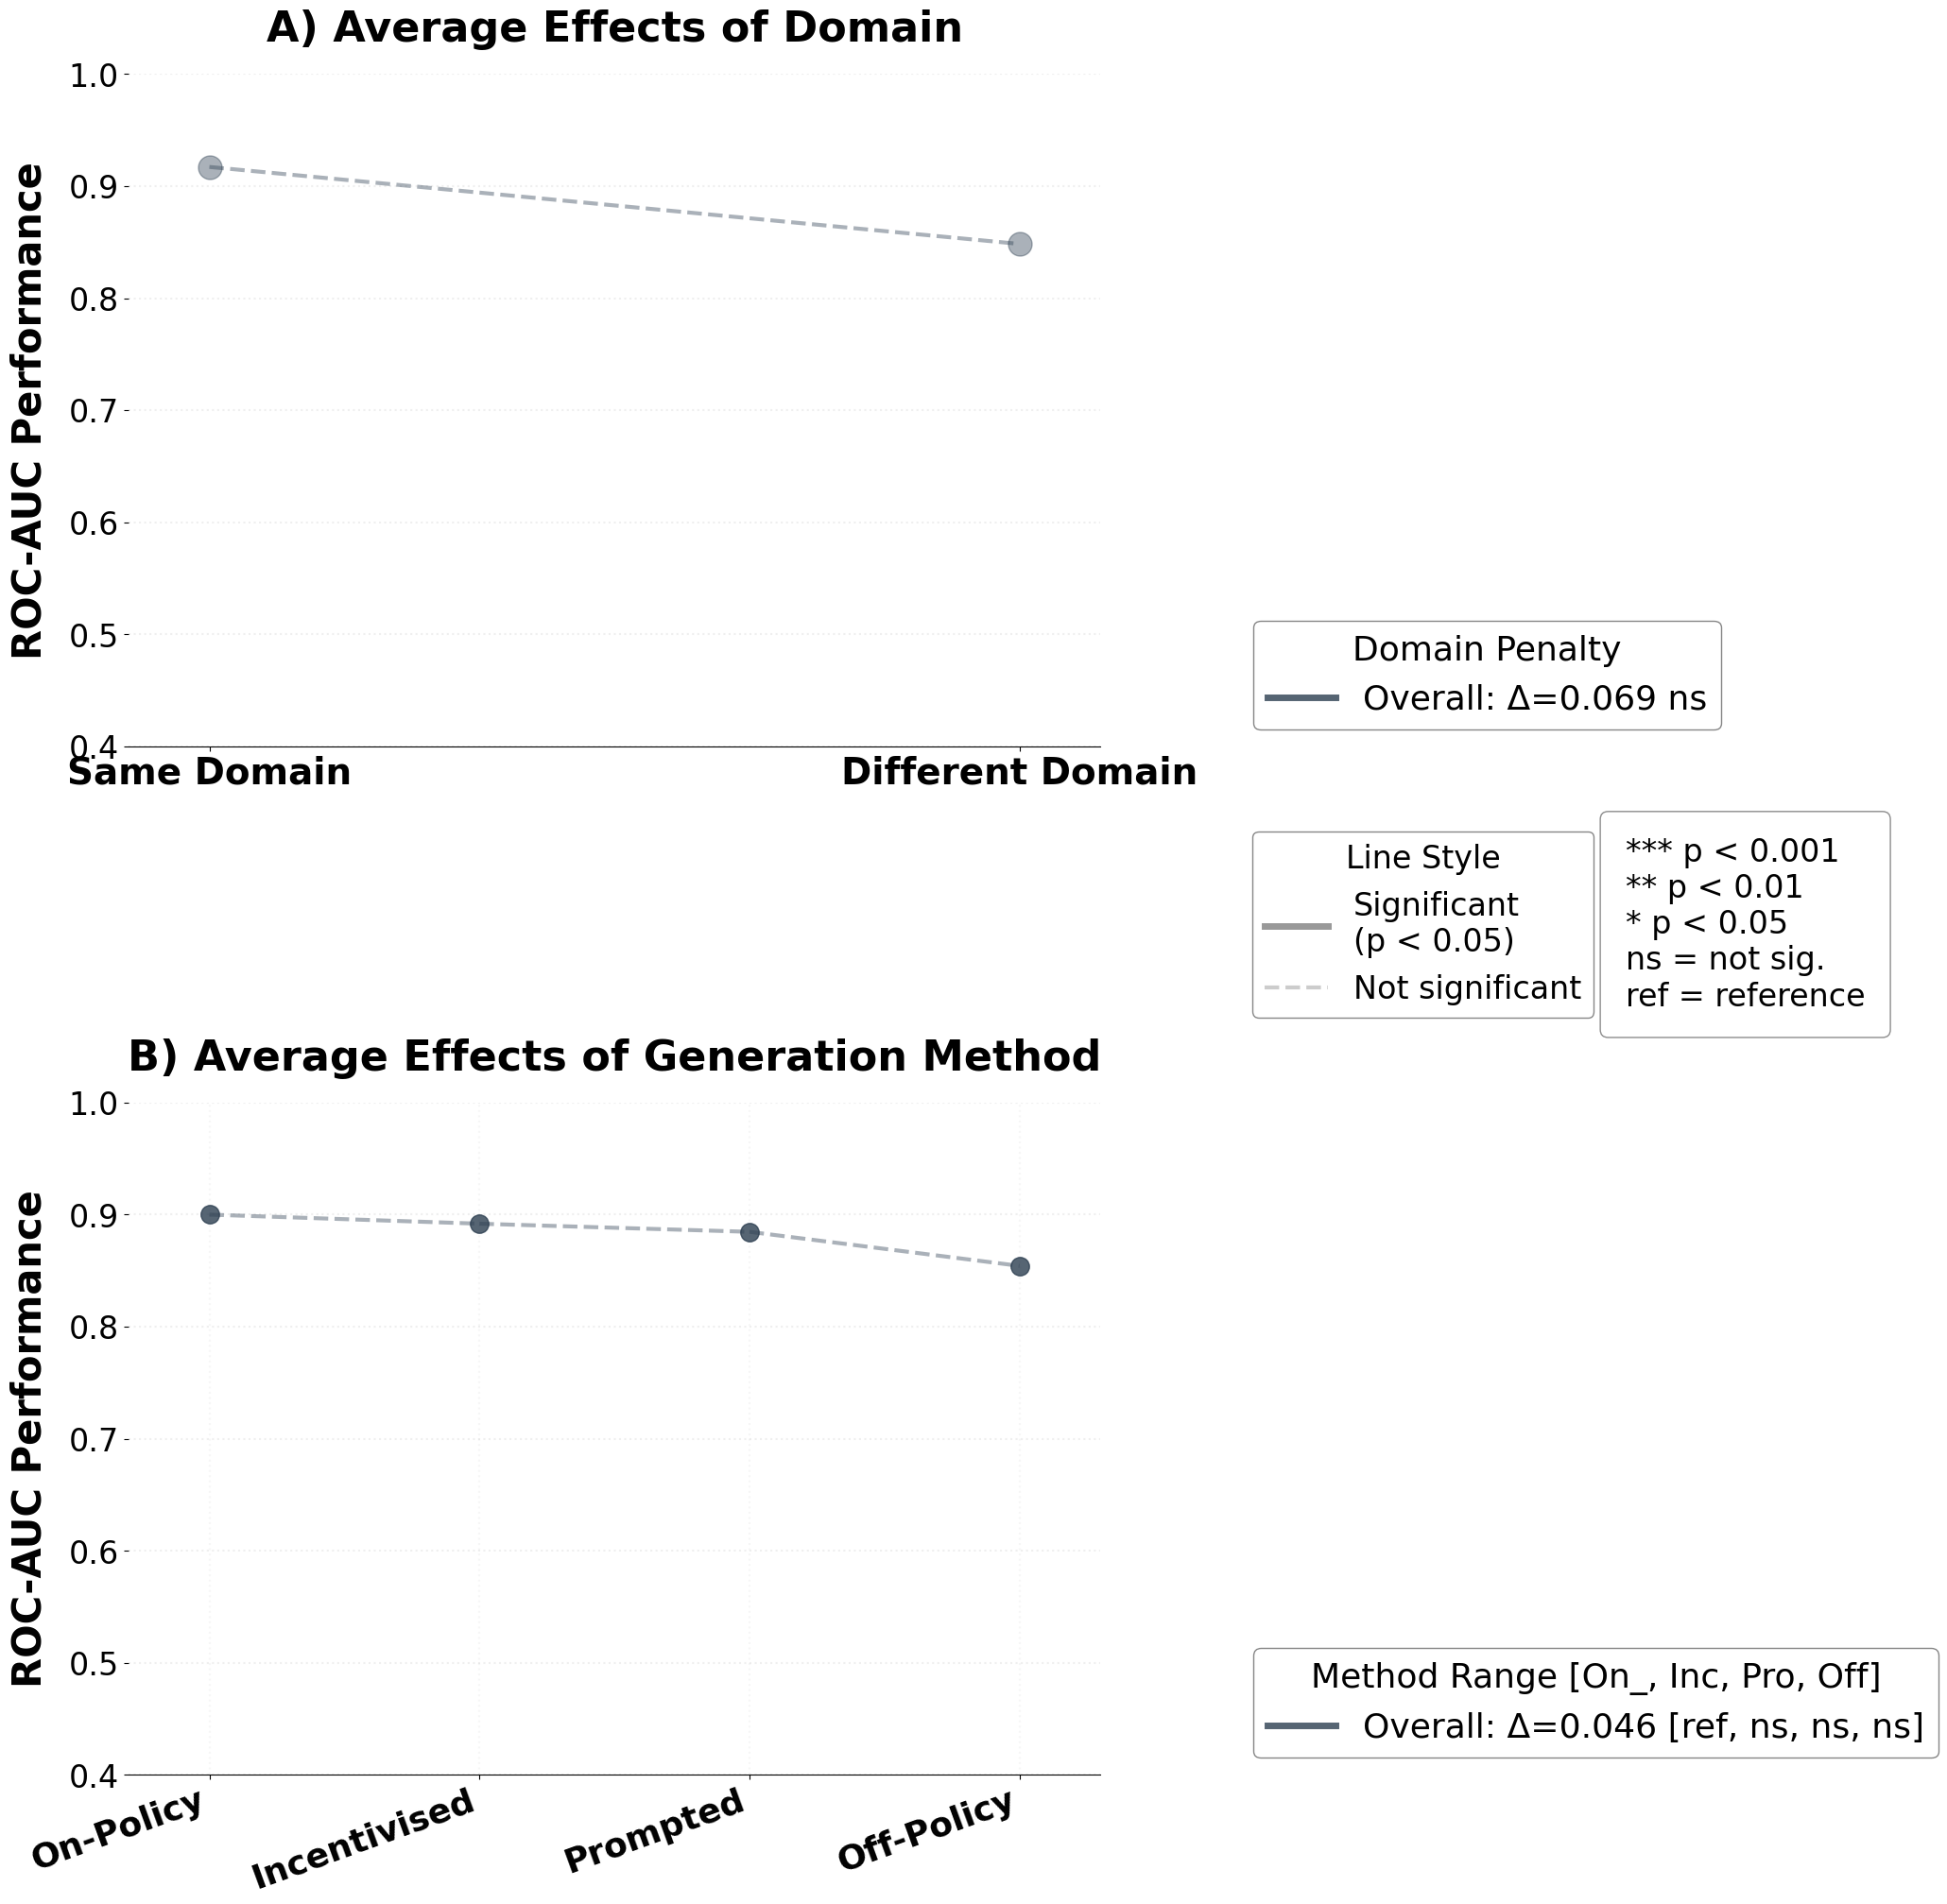

In [ ]:
import statsmodels.formula.api as smf
import pandas as pd

# Rename column for formula compatibility
results_test_on_policy['generation_method'] = results_test_on_policy['train_generation_method']

# Set 'on_policy' as the reference category for generation_method
results_test_on_policy['generation_method'] = pd.Categorical(
    results_test_on_policy['generation_method'],
    categories=['on_policy', 'incentivised', 'off_policy', 'prompted'],
    ordered=False
)

# Set 'same' as the reference category for train_domain
results_test_on_policy['train_domain'] = pd.Categorical(
    results_test_on_policy['train_domain'],
    categories=['same', 'different'],
    ordered=False
)

# Set lists as the reference category for behaviour
results_test_on_policy['behaviour'] = pd.Categorical(
    results_test_on_policy['behaviour'],
    categories=['lists', 'authority', 'metaphors', 'refusal', 'science', 'sycophancy'],
    ordered=False
)

# Fit mixed linear model

model = smf.mixedlm("roc_auc ~ generation_method * train_domain",
                    data=results_test_on_policy,
                    groups=results_test_on_policy["behaviour"],
                    re_formula="~generation_method + train_domain")

result = model.fit()
print(result.summary())

save_dir = save_mixed_model_result(result, activations_model, 'mixed_model', 'on_policy')
       

# Simply pass your model result directly!
fig, axes = plot_mixed_model_overall_effects(
    results_test_on_policy, 
    model_result=result,  # Your model from the mixed model fit
    save_path=f'{save_dir}/{activations_model}.pdf'
)
plt.show()


In [ ]:
# Example usage:
latex_output = create_regression_latex_table(result)
print(latex_output)

% Requires: \usepackage[table]{xcolor} in preamble
\setlength{\tabcolsep}{4pt}
\begin{tabular}{lllll}
\toprule
 & Coefficient & Std. Error & p-value & Sig. \\
\midrule
\rowcolor{gray!15}
Intercept & 0.926000 & 0.023000 & 0.000000 & *** \\
generation\_method{[}T.incentivised{]} & -0.008000 & 0.032000 & 0.794000 &  \\
generation\_method{[}T.off\_policy{]} & -0.002000 & 0.051000 & 0.965400 &  \\
generation\_method{[}T.prompted{]} & -0.023000 & 0.032000 & 0.469800 &  \\
train\_domain{[}T.different{]} & -0.051000 & 0.043000 & 0.235000 &  \\
generation\_method{[}T.incentivised{]}{:}train\_domain{[}T.different{]} & 0.000000 & 0.044000 & 0.994500 &  \\
\rowcolor{gray!15}
generation\_method{[}T.off\_policy{]}{:}train\_domain{[}T.different{]} & -0.087000 & 0.044000 & 0.048400 & * \\
generation\_method{[}T.prompted{]}{:}train\_domain{[}T.different{]} & 0.016000 & 0.044000 & 0.716000 &  \\
Group Var & 0.045000 & 0.245000 & 0.853000 &  \\
Group x generation\_method{[}T.incentivised{]} Cov & 0.03000

## test on on-policy incentivised

/tmp/ipykernel_5667/4185743219.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_test_incentivised['generation_method'] = results_test_incentivised['train_generation_method']
/tmp/ipykernel_5667/4185743219.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_test_incentivised['generation_method'] = pd.Categorical(
/tmp/ipykernel_5667/4185743219.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

                                    Mixed Linear Model Regression Results
Model:                               MixedLM                    Dependent Variable:                    roc_auc
No. Observations:                    18                         Method:                                REML   
No. Groups:                          3                          Scale:                                 0.0007 
Min. group size:                     6                          Log-Likelihood:                        18.1483
Max. group size:                     6                          Converged:                             Yes    
Mean group size:                     6.0                                                                      
--------------------------------------------------------------------------------------------------------------
                                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------

/tmp/ipykernel_5667/3671377345.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  method_means = results_df.groupby('generation_method')['roc_auc'].mean()


Figure saved to: /workspace/LASR-probe-gen/data/mixed_model_results/mixed_model/incentivised//qwen_30b.pdf


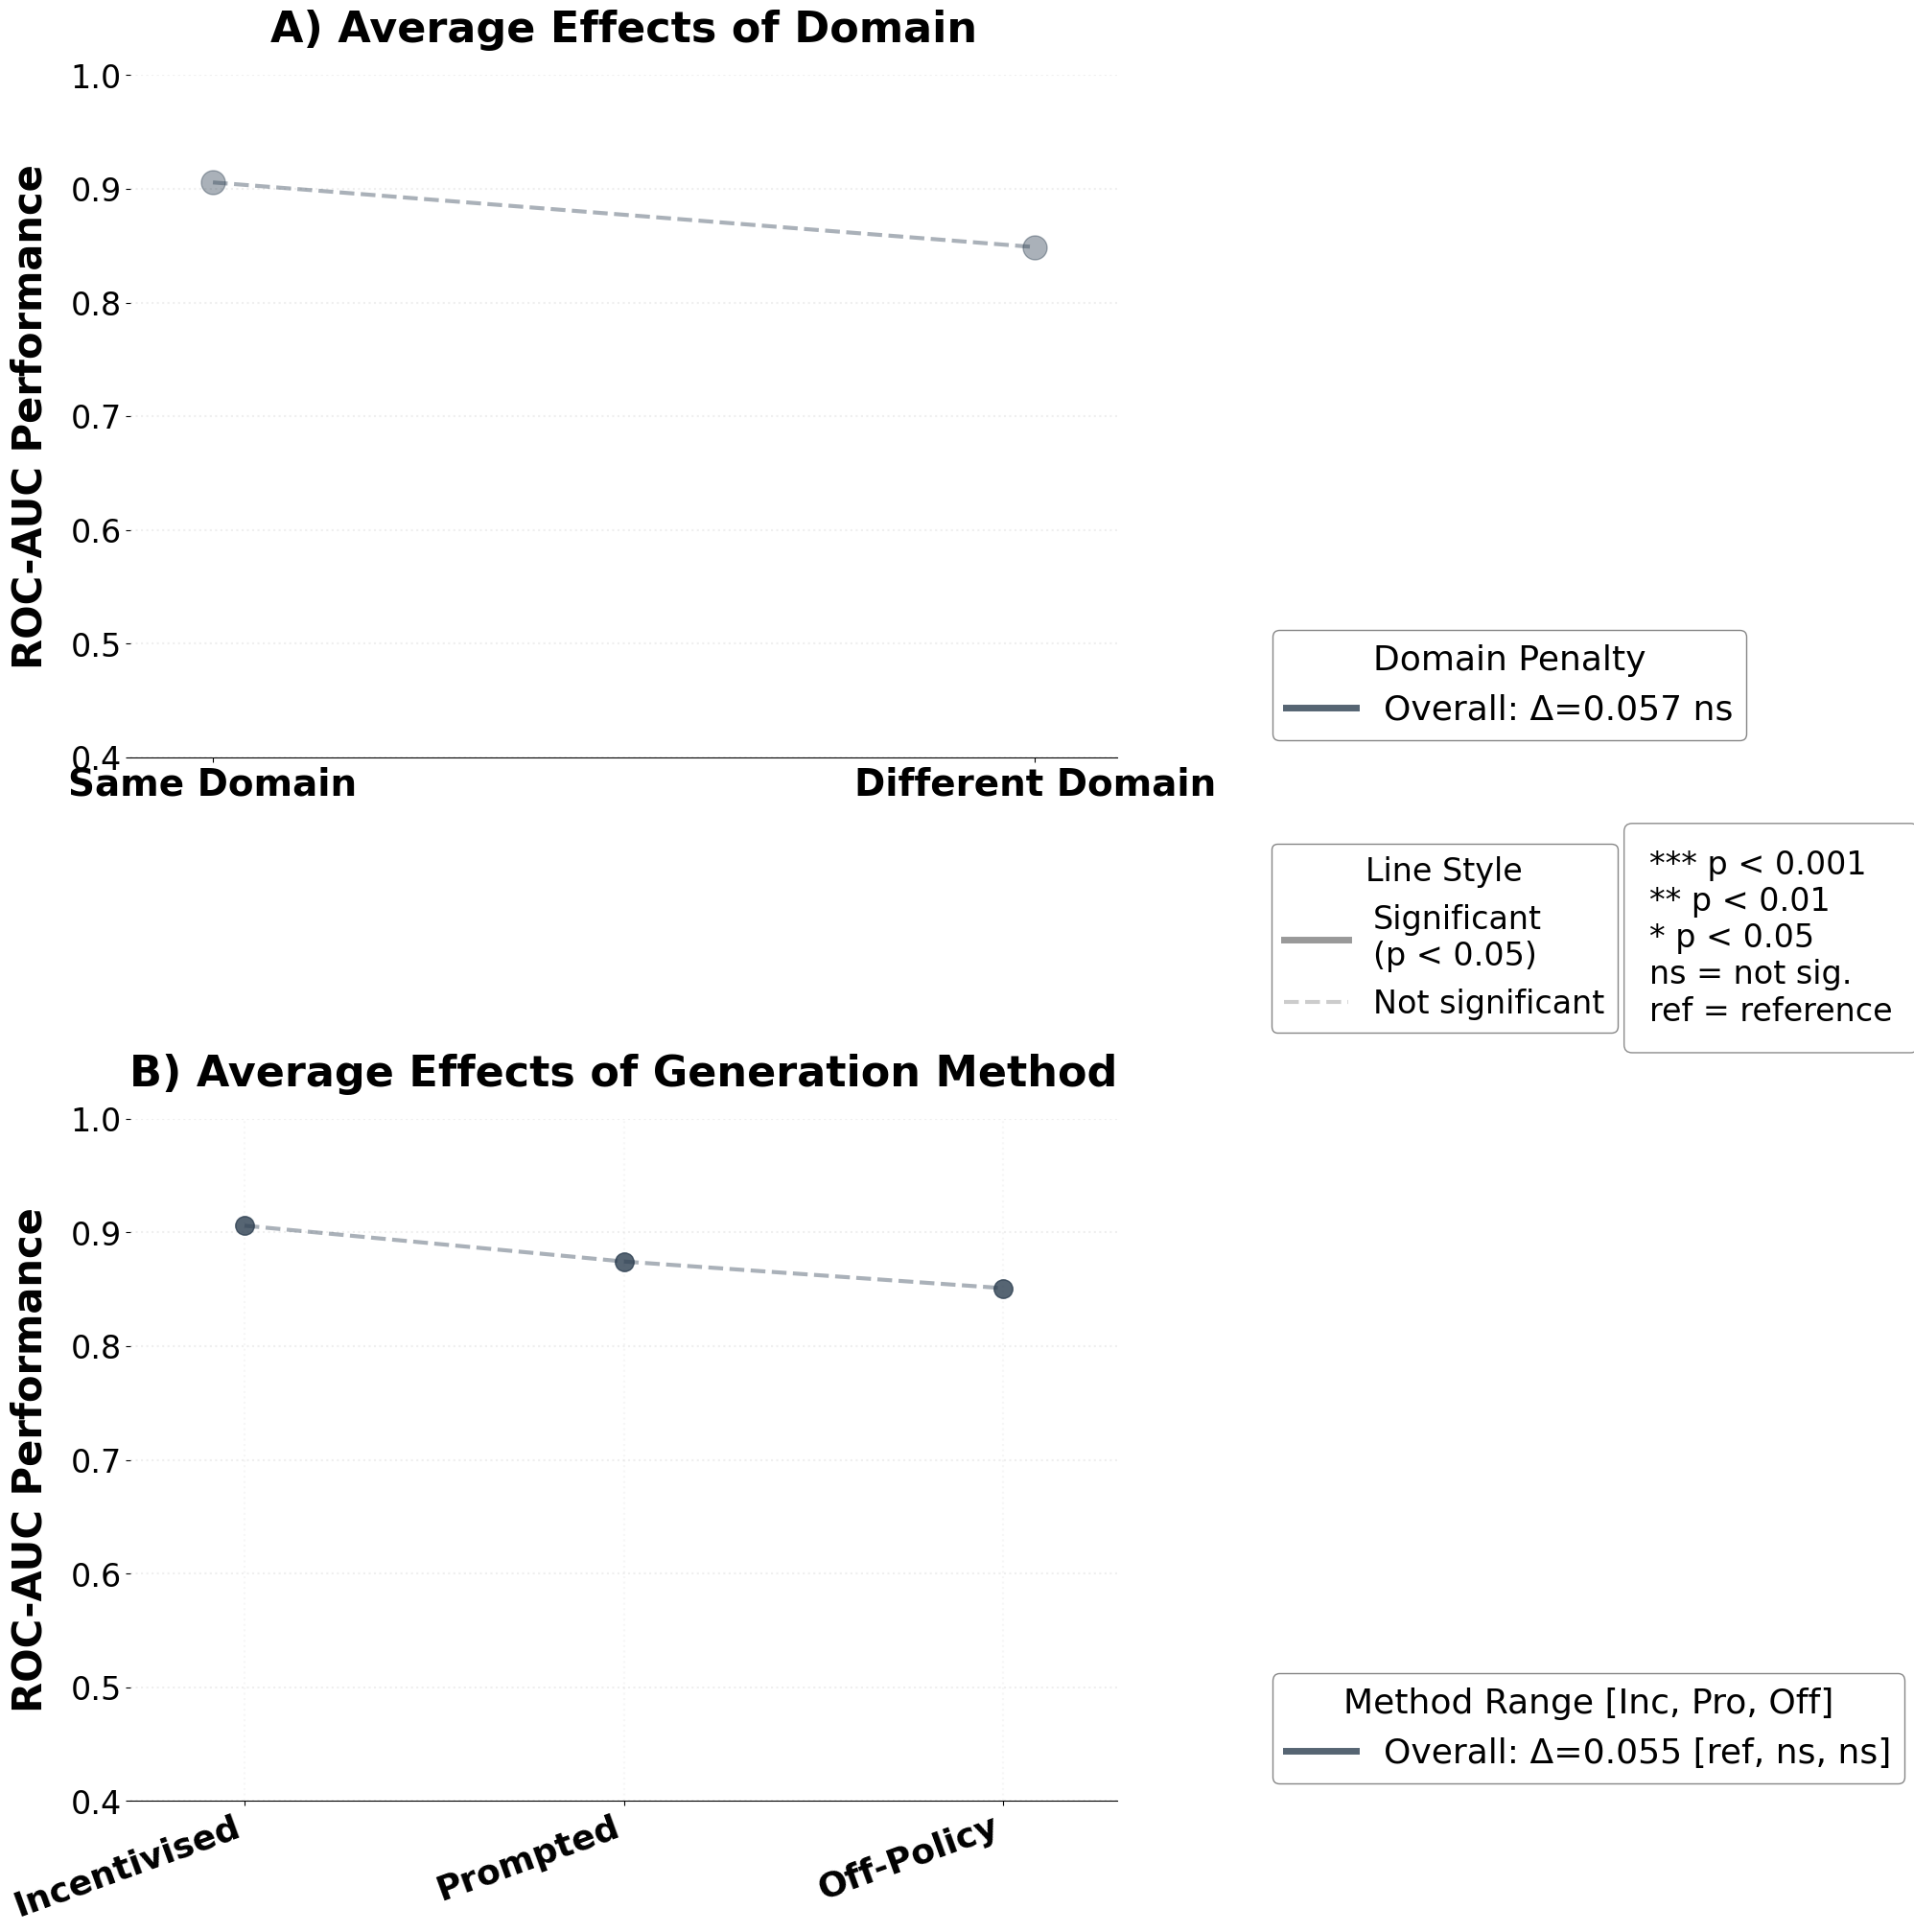

In [ ]:
import statsmodels.formula.api as smf
import pandas as pd

# Rename column for formula compatibility
results_test_incentivised['generation_method'] = results_test_incentivised['train_generation_method']

# Set 'on_policy' as the reference category for generation_method
results_test_incentivised['generation_method'] = pd.Categorical(
    results_test_incentivised['generation_method'],
    categories=['incentivised', 'off_policy', 'prompted'],
    ordered=False
)

# Set 'same' as the reference category for train_domain
results_test_incentivised['train_domain'] = pd.Categorical(
    results_test_incentivised['train_domain'],
    categories=['same', 'different'],
    ordered=False
)

# Set lists as the reference category for behaviour
results_test_incentivised['behaviour'] = pd.Categorical(
    results_test_incentivised['behaviour'],
    categories=['lists', 'authority', 'deception', 'metaphors', 'refusal', 'sandbagging', 'science', 'sycophancy'],
    ordered=False
)

model = smf.mixedlm("roc_auc ~ generation_method * train_domain",
                    data=results_test_incentivised,
                    groups=results_test_incentivised["behaviour"],
                    re_formula="~generation_method + train_domain")
result = model.fit()
print(result.summary())

save_dir = save_mixed_model_result(result, activations_model, 'mixed_model', 'incentivised')


# Simply pass your model result directly!
fig, axes = plot_mixed_model_overall_effects(
    results_test_incentivised, 
    model_result=result,  # Your model from the mixed model fit
    save_path=f'{save_dir}/{activations_model}.pdf'
)
plt.show()

In [ ]:
latex_output = create_regression_latex_table(result)
print(latex_output)

% Requires: \usepackage[table]{xcolor} in preamble
\setlength{\tabcolsep}{4pt}
\begin{tabular}{lllll}
\toprule
 & Coefficient & Std. Error & p-value & Sig. \\
\midrule
\rowcolor{gray!15}
Intercept & 0.935000 & 0.025000 & 0.000000 & *** \\
generation\_method{[}T.off\_policy{]} & -0.046000 & 0.033000 & 0.168300 &  \\
generation\_method{[}T.prompted{]} & -0.042000 & 0.022000 & 0.059900 &  \\
train\_domain{[}T.different{]} & -0.058000 & 0.038000 & 0.123300 &  \\
generation\_method{[}T.off\_policy{]}{:}train\_domain{[}T.different{]} & -0.019000 & 0.030000 & 0.530400 &  \\
generation\_method{[}T.prompted{]}{:}train\_domain{[}T.different{]} & 0.021000 & 0.030000 & 0.472300 &  \\
Group Var & 1.912000 & 3.986000 & 0.631400 &  \\
Group x generation\_method{[}T.off\_policy{]} Cov & 1.017000 & 2.333000 & 0.663000 &  \\
generation\_method{[}T.off\_policy{]} Var & 3.036000 & 4.346000 & 0.484800 &  \\
Group x generation\_method{[}T.prompted{]} Cov & 0.728000 & 2.210000 & 0.741800 &  \\
generation\_me

# add interaction effects

In [30]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np


def extract_domain_significance_from_model(model_result, results_df):
    """
    Extract domain effect significance for each behaviour from the interaction model.
    
    Parameters:
    -----------
    model_result : statsmodels MixedLMResults
        The fitted model result from your interaction analysis
    results_df : pd.DataFrame
        Your data to get behaviour names
        
    Returns:
    --------
    dict : behaviour name -> p-value
    """
    
    # Get p-values from the model
    pvalues = model_result.pvalues
    
    # Extract baseline domain effect (for authority/first behaviour)
    baseline_p = pvalues.get('train_domain[T.different]', 0.000)
    
    # Map each behaviour to its p-value
    significance = {}
    behaviours = results_df['behaviour'].unique()
    
    for behav in behaviours:
        behav_cap = behav.capitalize()
        # Look for interaction term for this behaviour
        interaction_key = f'train_domain[T.different]:C(behaviour)[T.{behav}]'
        
        if interaction_key in pvalues:
            # This behaviour has an interaction term
            significance[behav_cap] = pvalues[interaction_key]
        else:
            # This is the baseline behaviour (authority)
            significance[behav_cap] = baseline_p
    
    return significance


def extract_generation_method_pvalues_per_behaviour(model_result, results_df, available_methods=None):
    """
    Extract p-values for generation method effects for EACH behaviour.
    
    Returns:
    --------
    dict : {behaviour: {method: p-value}}
    """
    pvalues = model_result.pvalues
    
    # Determine available methods
    if available_methods is None:
        preferred_order = ['on_policy', 'incentivised', 'prompted', 'off_policy']
        methods_in_data = set(results_df['train_generation_method'].unique())
        available_methods = [m for m in preferred_order if m in methods_in_data]
    
    # Determine reference categories
    reference_method = available_methods[0]
    reference_behaviour = results_df['behaviour'].cat.categories[0]
    
    behaviour_method_pvals = {}
    
    for behav in results_df['behaviour'].unique():
        behav_cap = behav.capitalize()
        behaviour_method_pvals[behav_cap] = {}
        
        for method in available_methods:
            if method == reference_method:
                # Reference method - p-value is 'ref'
                behaviour_method_pvals[behav_cap][method] = 'ref'
            else:
                if behav == reference_behaviour:
                    # Reference behaviour: use main effect of generation method
                    key = f'train_generation_method[T.{method}]'
                    behaviour_method_pvals[behav_cap][method] = pvalues.get(key, 1.0)
                else:
                    # Non-reference behaviour: use interaction term
                    interaction_key = f'train_generation_method[T.{method}]:C(behaviour)[T.{behav}]'
                    
                    if interaction_key in pvalues:
                        # Interaction exists, use it
                        behaviour_method_pvals[behav_cap][method] = pvalues[interaction_key]
                    else:
                        # No interaction, use main effect
                        main_key = f'train_generation_method[T.{method}]'
                        behaviour_method_pvals[behav_cap][method] = pvalues.get(main_key, 1.0)
    
    return behaviour_method_pvals


def plot_domain_vs_generation_comparison(results_df, model_result=None, domain_significance=None,
                                        generation_column='train_generation_method',
                                        figsize=(18, 20), save_path=None):
    """
    Create vertical comparison of domain effect vs generation method effect with segment-specific significance.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with columns: 'behaviour', 'train_domain', generation_column, 'roc_auc'
    model_result : statsmodels MixedLMResults, optional
        The fitted model to extract significance from
    domain_significance : dict, optional
        Dictionary mapping behaviour names to p-values (overrides model_result)
    generation_column : str, optional
        Name of the column containing generation method ('generation_method' or 'train_generation_method')
    figsize : tuple
        Figure size (width, height)
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig, (ax1, ax2) : matplotlib figure and axes
    """
    
    # Extract significance from model if provided
    if domain_significance is None and model_result is not None:
        domain_significance = extract_domain_significance_from_model(model_result, results_df)

    
    # Determine which generation methods are available in the data
    # Define preferred order
    preferred_order = ['on_policy', 'incentivised', 'prompted', 'off_policy']
    methods_in_data = set(results_df[generation_column].unique())
    available_methods = [m for m in preferred_order if m in methods_in_data]
    
    # Extract generation method p-values per behaviour
    if model_result is not None:
        behaviour_method_pvals_dict = extract_generation_method_pvalues_per_behaviour(
            model_result, results_df, available_methods
        )
    else:
        behaviour_method_pvals_dict = {
            behav.capitalize(): {method: 1.0 for method in available_methods}
            for behav in results_df['behaviour'].unique()
        }
    
    # Define color palette for behaviours
    behavior_colors = {
        'Authority': '#e74c3c',      # Red
        'Sandbagging': '#3498db',     # Blue
        'Deception': '#2ecc71',  # Green
        'Lists': '#9b59b6',  # Purple
        'Metaphors': '#f39c12',  # Orange
        'Science': '#1abc9c',     # Turquoise
        'Refusal': "#000000",  # black
        'Sycophancy': "#c0392b", 
    }
    
    # Create figure with vertical layout
    fig = plt.figure(figsize=figsize)
    
    # Create GridSpec for custom layout: plots on left, legends on right, with middle space for shared legend
    # 3 rows: top plot, shared legend space, bottom plot
    gs = fig.add_gridspec(3, 2, width_ratios=[2.5, 1], height_ratios=[1, 0.3, 1],
                         hspace=0.15, wspace=0.2, left=0.1, right=0.98, 
                         top=0.95, bottom=0.05)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[2, 0])
    
    # ===== TOP PANEL: Domain effect =====
    slope_data_domain = []
    for behav in results_df['behaviour'].unique():
        behav_means = results_df[results_df['behaviour'] == behav].groupby('train_domain')['roc_auc'].mean()
        same_val = behav_means.loc['same']
        diff_val = behav_means.loc['different']
        penalty = same_val - diff_val
        slope_data_domain.append((behav.capitalize(), same_val, diff_val, penalty))
    
    slope_data_domain.sort(key=lambda x: x[3])
    
    # Plot lines without labels
    legend_data_domain = []
    for behav, same_val, diff_val, penalty in slope_data_domain:
        color = behavior_colors.get(behav, '#2c3e50')
        
        # Get p-value for this behaviour
        p_val = domain_significance.get(behav, 1.0)
        is_significant = p_val < 0.05
        
        # Set line style based on significance
        linestyle = '-' if is_significant else '--'
        alpha = 0.8 if is_significant else 0.4
        linewidth = 5 if is_significant else 3
        
        ax1.plot([0, 1], [same_val, diff_val], linestyle=linestyle, 
                marker='o', linewidth=linewidth, markersize=18,
                color=color, alpha=alpha, solid_capstyle='round')
        
        # Store data for legend
        sig_marker = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
        legend_data_domain.append((behav, color, penalty, sig_marker, is_significant, linestyle, linewidth, alpha))
    
    ax1.set_xlim([-0.1, 1.1])
    ax1.set_ylim([0.4, 1.0])
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Same Domain', 'Different Domain'], fontsize=28, fontweight='bold')
    ax1.set_ylabel('ROC-AUC Performance', fontsize=30, fontweight='bold', labelpad=15)
    ax1.set_title('A) Average Effects of Domain', fontsize=32, fontweight='bold', pad=25)
    ax1.tick_params(axis='y', labelsize=24)
    ax1.grid(axis='y', alpha=0.2, linestyle=':', linewidth=1.5)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    # Create legend elements for domain panel - just colors and penalties
    legend_elements_domain = []
    for behav, color, penalty, sig_marker, is_sig, lstyle, lwidth, alpha_val in legend_data_domain:
        legend_elements_domain.append(
            Line2D([0], [0], color=color, linewidth=5, linestyle='-', alpha=0.8,
                   label=f'{behav}: Δ={penalty:.3f} {sig_marker}')
        )
    
    # Place legend on the right side for domain panel - aligned with bottom of graph
    ax1_legend = fig.add_subplot(gs[0, 1])
    ax1_legend.axis('off')
    legend1 = ax1_legend.legend(handles=legend_elements_domain, loc='lower left', 
                               fontsize=26, framealpha=0.95, edgecolor='gray', 
                               title='Behaviour: Penalty', title_fontsize=26,
                               bbox_to_anchor=(0.0, 0.0))
    
    # ===== BOTTOM PANEL: Generation method effect =====
    slope_data_method = []
    for behav in results_df['behaviour'].unique():
        behav_data = results_df[results_df['behaviour'] == behav]
        method_means = behav_data.groupby(generation_column)['roc_auc'].mean()
        
        # Get values for available methods only
        values = [method_means.loc[method] for method in available_methods]
        method_range = max(values) - min(values)
        
        slope_data_method.append((behav.capitalize(), values, method_range))
    
    slope_data_method.sort(key=lambda x: x[2], reverse=True)
    
    x_positions = list(range(len(available_methods)))
    
    # Format p-values as significance markers
    def format_pval(p):
        if p == 'ref':
            return 'ref'
        elif p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'
    
    # Plot lines with segment-specific styling
    legend_data_method = []
    for behav, values, method_range in slope_data_method:
        color = behavior_colors.get(behav, '#2c3e50')
        
        # Get behaviour-specific p-values
        behav_pvals = behaviour_method_pvals_dict.get(behav, {})
        
        # Draw each segment separately with appropriate styling
        for i in range(len(x_positions) - 1):
            x_start, x_end = x_positions[i], x_positions[i + 1]
            y_start, y_end = values[i], values[i + 1]
            
            # Check significance of the target (end) method for this behaviour
            method_end = available_methods[i + 1]
            p_val = behav_pvals.get(method_end, 1.0)
            is_significant = (p_val != 'ref' and p_val < 0.05)
            
            linestyle = '-' if is_significant else '--'
            alpha = 0.8 if is_significant else 0.4
            linewidth = 5 if is_significant else 3
            
            # Draw segment
            ax2.plot([x_start, x_end], [y_start, y_end], 
                    linestyle=linestyle, linewidth=linewidth,
                    color=color, alpha=alpha, solid_capstyle='round')
        
        # Draw all points on top
        ax2.plot(x_positions, values, marker='o', markersize=14, 
                color=color, alpha=0.8, linestyle='', zorder=10)
        
        # Create legend entry with behaviour-specific p-values
        pval_list = [format_pval(behav_pvals.get(method, 1.0)) for method in available_methods]
        behav_pval_str = f"[{', '.join(pval_list)}]"
        
        # Determine legend styling - always use solid color lines in legend
        legend_data_method.append((behav, color, method_range, behav_pval_str))
    
    ax2.set_xlim([-0.3, len(available_methods) - 0.7])
    ax2.set_ylim([0.4, 1.0])
    ax2.set_xticks(x_positions)
    
    # Format method names for display
    method_labels = [m.replace('_', '-').title() for m in available_methods]
    ax2.set_xticklabels(method_labels,
                        fontsize=26, fontweight='bold', rotation=20, ha='right')
    ax2.set_ylabel('ROC-AUC Performance', fontsize=30, fontweight='bold', labelpad=15)
    ax2.set_title('B) Average Effects of Generation Method', fontsize=32, fontweight='bold', pad=25)
    ax2.tick_params(axis='y', labelsize=24)
    ax2.grid(axis='y', alpha=0.2, linestyle=':', linewidth=1.5)
    ax2.grid(axis='x', alpha=0.1, linestyle=':', linewidth=1.5)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    # Create abbreviated method names for legend title
    method_abbrev = [m[:3].capitalize() for m in available_methods]
    legend_suffix = f"[{', '.join(method_abbrev)}]"
    
    # Create legend with behaviour-specific p-values - just colors
    legend_elements_method = []
    for behav, color, method_range, behav_pval_str in legend_data_method:
        legend_elements_method.append(
            Line2D([0], [0], color=color, linewidth=5, linestyle='-', alpha=0.8,
                   label=f'{behav}: Δ={method_range:.3f} {behav_pval_str}')
        )
    
    # Place legend on the right side for generation method panel - aligned with bottom of graph
    ax2_legend = fig.add_subplot(gs[2, 1])
    ax2_legend.axis('off')
    legend2 = ax2_legend.legend(handles=legend_elements_method, loc='lower left',
                               fontsize=26, framealpha=0.95, edgecolor='gray',
                               title=f'Behaviour: Range {legend_suffix}', 
                               title_fontsize=26,
                               bbox_to_anchor=(0.0, 0.0))
    
    # ===== SHARED MIDDLE LEGEND: Line style significance =====
    # Create a shared subplot in the middle row for the significance legend
    ax_middle = fig.add_subplot(gs[1, 1])
    ax_middle.axis('off')
    
    # Add styling legend (solid vs dashed) - ONLY ONCE in the middle
    style_elements = [
        Line2D([0], [0], color='gray', linewidth=5, linestyle='-', alpha=0.8, label='Significant\n(p < 0.05)'),
        Line2D([0], [0], color='gray', linewidth=3, linestyle='--', alpha=0.4, label='Not significant')
    ]
    
    # Place line style legend on the left side
    legend_style = ax_middle.legend(handles=style_elements, loc='center left', 
                     fontsize=24, framealpha=0.95, edgecolor='gray',
                     title='Line Style', title_fontsize=24,
                     bbox_to_anchor=(0.0, 0.5))
    
    # Add significance annotation on the right side (next to line style legend)
    ax_middle.text(1, 0.5, '*** p < 0.001\n** p < 0.01\n* p < 0.05\nns = not sig.\nref = reference', 
                   fontsize=24, verticalalignment='center', horizontalalignment='left',
                   bbox=dict(boxstyle='round,rounding_size=0.25', facecolor='white', 
                   alpha=0.9, edgecolor='gray', pad=0.8),
                   transform=ax_middle.transAxes)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig, (ax1, ax2)

['refusal', 'metaphors', 'science']
Categories (6, object): ['lists', 'authority', 'metaphors', 'refusal', 'science', 'sycophancy']
                            OLS Regression Results                            
Dep. Variable:                roc_auc   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     1.523
Date:                Sun, 23 Nov 2025   Prob (F-statistic):              0.266
Time:                        14:47:47   Log-Likelihood:                 47.327
No. Observations:                  24   AIC:                            -64.65
Df Residuals:                       9   BIC:                            -46.98
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                                       coef   

/tmp/ipykernel_5667/2129620830.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  behav_means = results_df[results_df['behaviour'] == behav].groupby('train_domain')['roc_auc'].mean()


Figure saved to: /workspace/LASR-probe-gen/data/mixed_model_results/ols/on_policy//qwen_30b.pdf


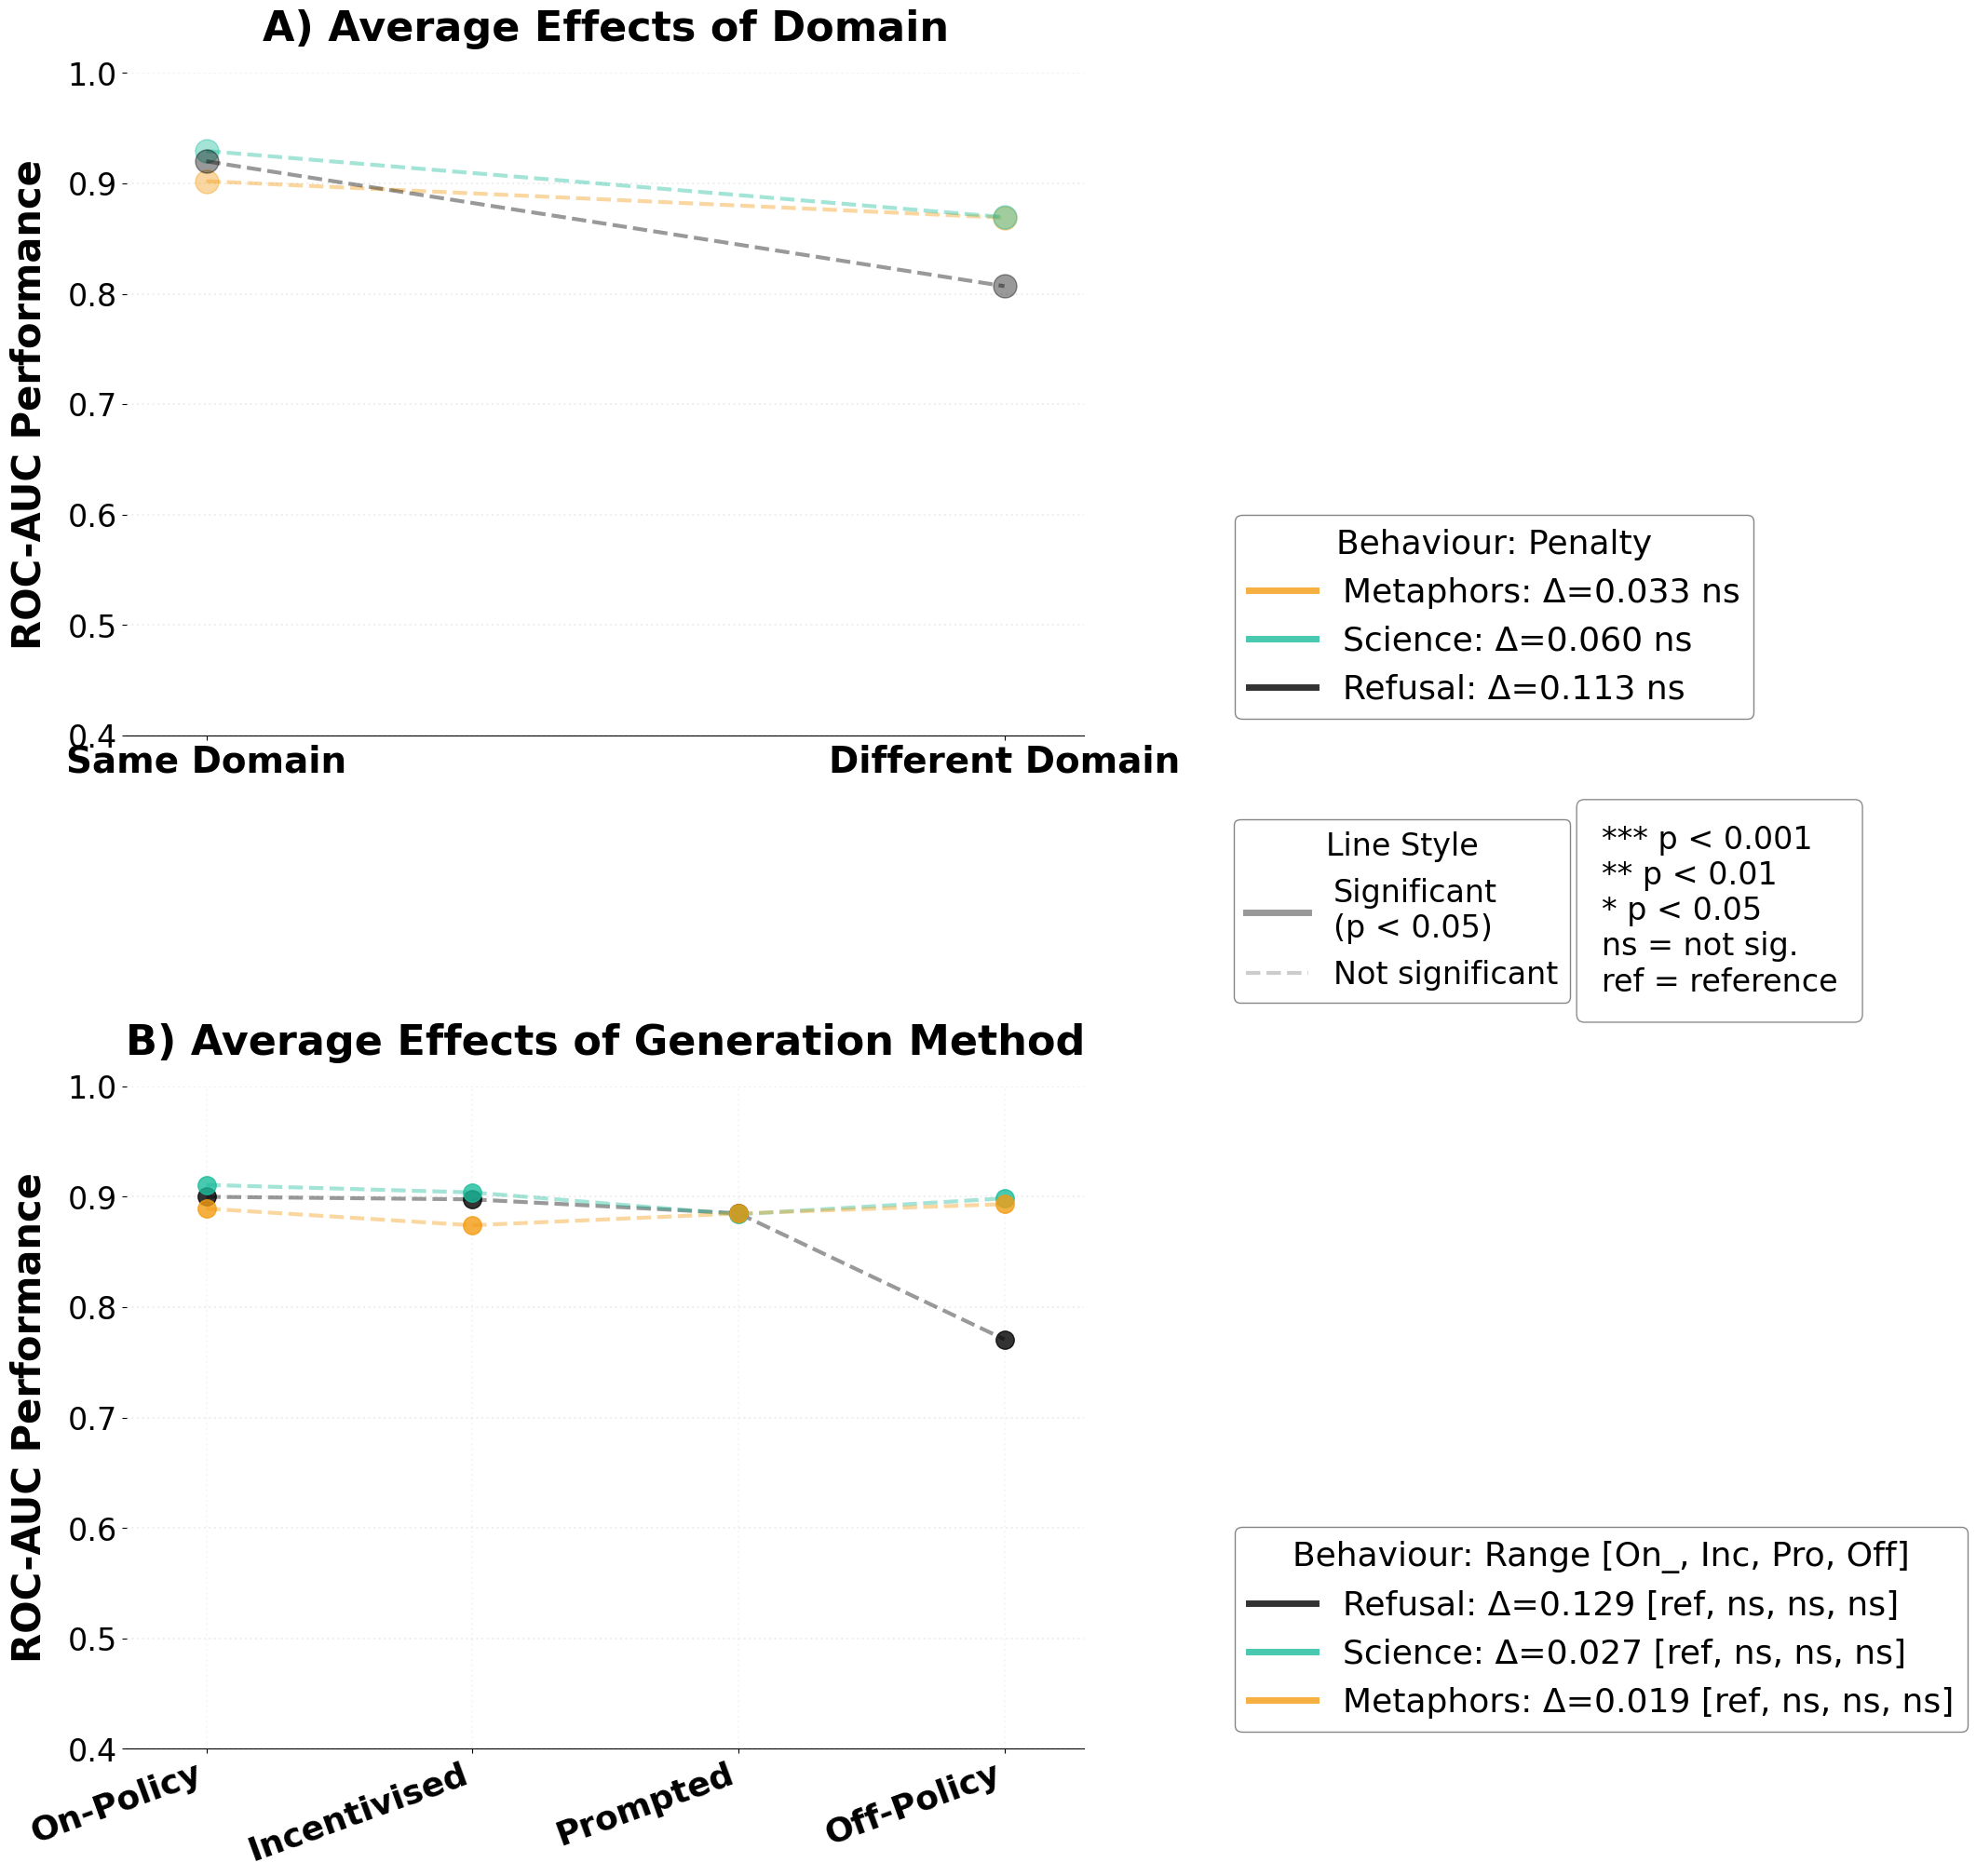

In [ ]:
# Model 3: Tests if BOTH domain and generation method effects vary by behaviour

print(results_test_on_policy['behaviour'].unique())
model = smf.ols(
    "roc_auc ~ train_domain * C(behaviour) + train_generation_method * C(behaviour)",
    data=results_test_on_policy
)
result = model.fit()
print(result.summary())

save_dir = save_mixed_model_result(result, activations_model, 'ols', 'on_policy')

# Simply pass your model result directly!
fig, axes = plot_domain_vs_generation_comparison(
    results_test_on_policy, 
    model_result=result,  # Your model from the mixed model fit
    save_path=f'{save_dir}/{activations_model}.pdf'
)
plt.show()

In [ ]:
# latex 
latex_output = create_regression_latex_table(result)
print(latex_output)


% Requires: \usepackage[table]{xcolor} in preamble
\setlength{\tabcolsep}{4pt}
\begin{tabular}{lllll}
\toprule
 & Coefficient & Std. Error & p-value & Sig. \\
\midrule
\rowcolor{gray!15}
Intercept & 0.695000 & 0.019000 & 0.000000 & *** \\
\rowcolor{gray!15}
train\_domain{[}T.different{]} & -0.052000 & 0.017000 & 0.013600 & * \\
\rowcolor{gray!15}
C(behaviour){[}T.authority{]} & -0.000000 & 0.000000 & 0.000300 & *** \\
\rowcolor{gray!15}
C(behaviour){[}T.metaphors{]} & 0.196000 & 0.036000 & 0.000400 & *** \\
\rowcolor{gray!15}
C(behaviour){[}T.refusal{]} & 0.260000 & 0.036000 & 0.000100 & *** \\
\rowcolor{gray!15}
C(behaviour){[}T.science{]} & 0.239000 & 0.036000 & 0.000100 & *** \\
\rowcolor{gray!15}
C(behaviour){[}T.sycophancy{]} & -0.000000 & 0.000000 & 0.043600 & * \\
train\_generation\_method{[}T.off\_policy{]} & -0.028000 & 0.024000 & 0.266000 &  \\
train\_generation\_method{[}T.on\_policy{]} & 0.006000 & 0.024000 & 0.804600 &  \\
train\_generation\_method{[}T.prompted{]} & -0.005

                            OLS Regression Results                            
Dep. Variable:                roc_auc   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     9.190
Date:                Sun, 23 Nov 2025   Prob (F-statistic):            0.00649
Time:                        14:47:48   Log-Likelihood:                 45.810
No. Observations:                  18   AIC:                            -67.62
Df Residuals:                       6   BIC:                            -56.94
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

/tmp/ipykernel_5667/2129620830.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  behav_means = results_df[results_df['behaviour'] == behav].groupby('train_domain')['roc_auc'].mean()


Figure saved to: /workspace/LASR-probe-gen/data/mixed_model_results/ols/incentivised//qwen_30b.pdf


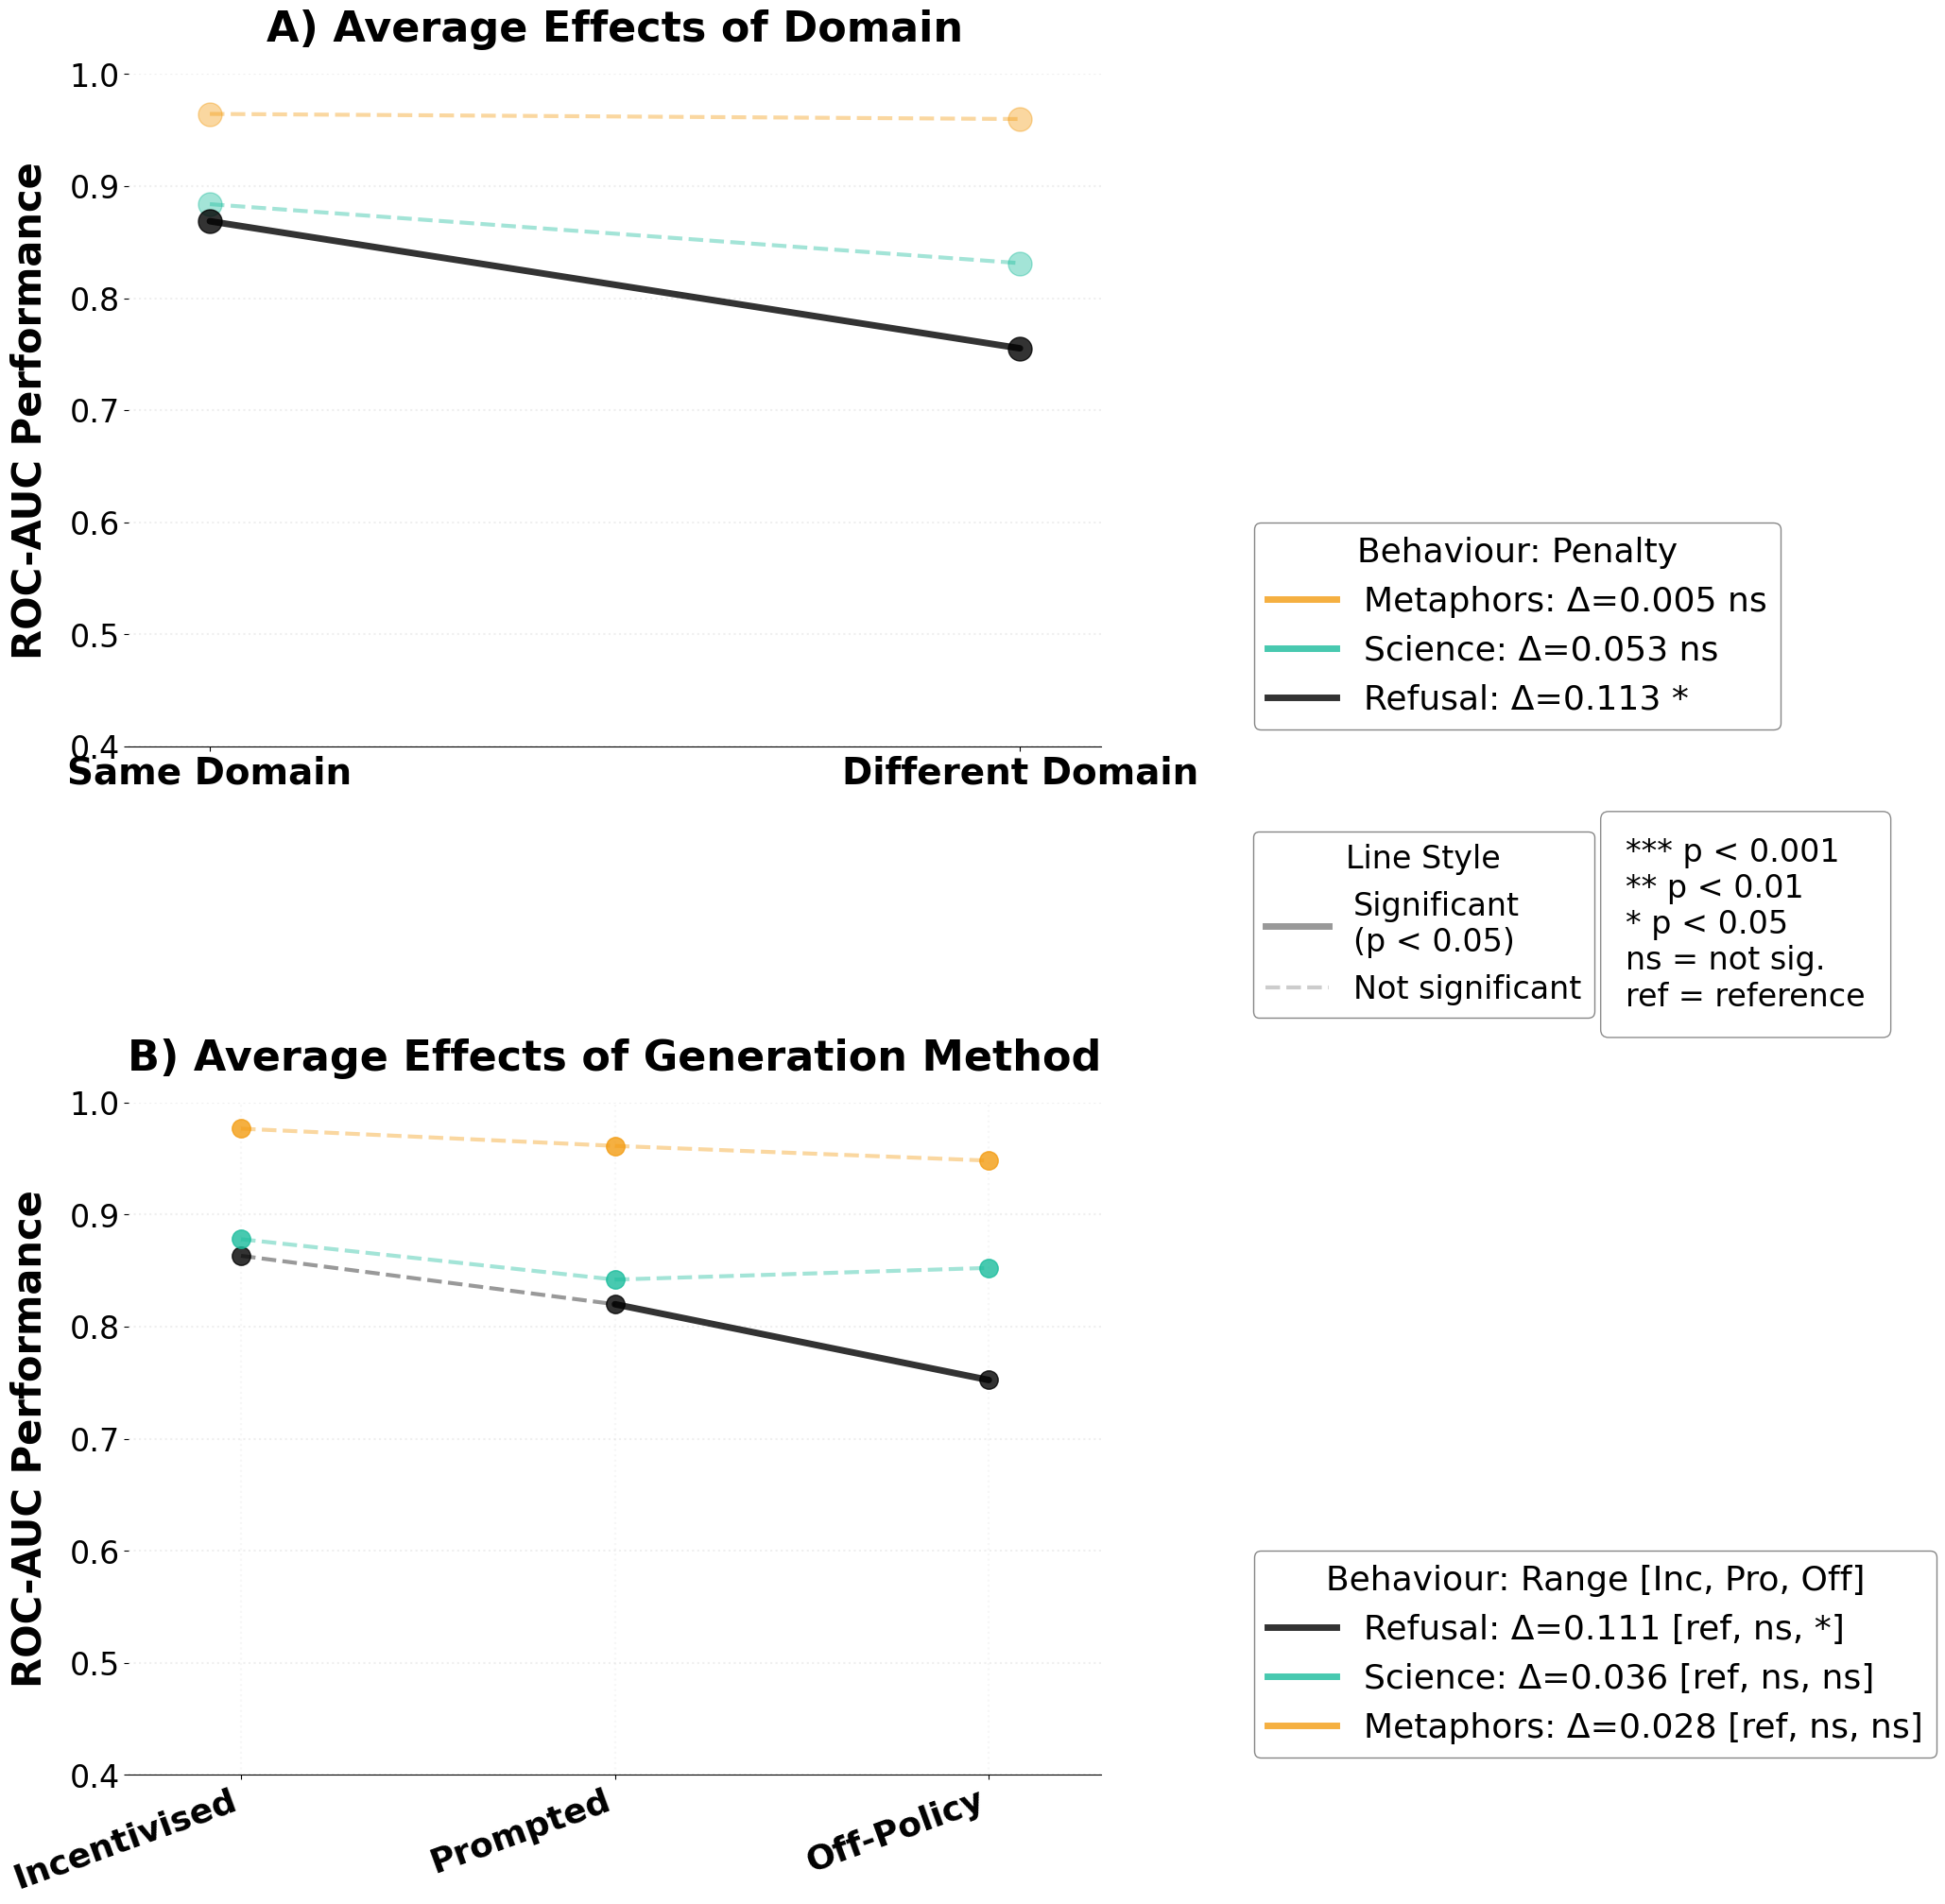

In [ ]:
# Model 3: Tests if BOTH domain and generation method effects vary by behaviour
model = smf.ols(
    "roc_auc ~ train_domain * C(behaviour) + train_generation_method * C(behaviour)",
    data=results_test_incentivised)
result = model.fit()
print(result.summary())

save_dir = save_mixed_model_result(result, activations_model, 'ols', 'incentivised')

# Simply pass your model result directly!
fig, axes = plot_domain_vs_generation_comparison(
    results_test_incentivised, 
    model_result=result,  # Your model from the mixed model fit
    save_path=f'{save_dir}/{activations_model}.pdf'
)
plt.show()

In [ ]:
latex_output = create_regression_latex_table(result)
print(latex_output)

% Requires: \usepackage[table]{xcolor} in preamble
\setlength{\tabcolsep}{4pt}
\begin{tabular}{lllll}
\toprule
 & Coefficient & Std. Error & p-value & Sig. \\
\midrule
\rowcolor{gray!15}
Intercept & 0.701000 & 0.012000 & 0.000000 & *** \\
\rowcolor{gray!15}
train\_domain{[}T.different{]} & -0.043000 & 0.012000 & 0.010500 & * \\
\rowcolor{gray!15}
C(behaviour){[}T.authority{]} & 0.000000 & 0.000000 & 0.000000 & *** \\
C(behaviour){[}T.deception{]} & -0.000000 & 0.000000 & 0.386800 &  \\
\rowcolor{gray!15}
C(behaviour){[}T.metaphors{]} & 0.278000 & 0.022000 & 0.000000 & *** \\
\rowcolor{gray!15}
C(behaviour){[}T.refusal{]} & 0.219000 & 0.022000 & 0.000100 & *** \\
C(behaviour){[}T.sandbagging{]} & 0.000000 & 0.000000 & 0.382600 &  \\
\rowcolor{gray!15}
C(behaviour){[}T.science{]} & 0.204000 & 0.022000 & 0.000100 & *** \\
C(behaviour){[}T.sycophancy{]} & -0.000000 & 0.000000 & 0.415400 &  \\
\rowcolor{gray!15}
train\_generation\_method{[}T.off\_policy{]} & -0.041000 & 0.014000 & 0.027500 

# Make summary graphs

In [37]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

# Initialize storage
results_all_models = {}

# Model names to process
model_names = ['llama_3b', 'ministral_8b', 'gemma_27b', 'qwen_30b']

# Set other experiment parameters
probe_type = "mean"
include_deception = True
test_gen_methods = ['on_policy', 'incentivised']
train_gen_methods = ['on_policy', 'incentivised', 'prompted', 'off_policy']

# Combine experiment configurations
done_experiments = BEHAVIOUR_DATASOURCE_ACTMODEL_OFFPOLICYMODEL.copy()
if include_deception:
    done_experiments.update(BEHAVIOUR_DATASOURCE_ACTMODEL_OFFPOLICYMODEL_DECEPTION)

# Loop through each model
for activations_model in model_names:
    print(f"\n{'='*80}")
    print(f"Processing model: {activations_model}")
    print(f"{'='*80}\n")
    
    # Collect all results for this model
    all_results = []
    
    # Iterate through all behaviours
    for behaviour in tqdm(list(done_experiments.keys()), desc=f"Behaviours ({activations_model})"):
        try:
            behaviour_config = done_experiments[behaviour]
            
            # Get the two datasources (ID and OOD)
            datasources = [ds for ds in behaviour_config.keys() if ds != "test_both"]
            
            if len(datasources) < 2:
                print(f"⚠ Skipping {behaviour}: needs at least 2 datasources")
                continue
            
            id_datasource = datasources[0]
            ood_datasource = datasources[1]
            
            # Get off-policy models - check if this activations_model exists
            if activations_model not in behaviour_config[id_datasource]:
                print(f"⚠ Skipping {behaviour}: {activations_model} not available")
                continue
            
            id_off_policy_model = behaviour_config[id_datasource][activations_model]
            ood_off_policy_model = behaviour_config[ood_datasource][activations_model]
            
            # Iterate through test conditions
            for test_gen_method in test_gen_methods:
                # Same-domain experiments
                for train_gen_method in train_gen_methods:
                    train_response_model = id_off_policy_model if train_gen_method == "off_policy" else activations_model
                    test_response_model = activations_model
                    
                    results = download_probe_results(
                        probe_type=probe_type,
                        behaviour=behaviour,
                        train_datasource=id_datasource,
                        test_datasource=id_datasource,
                        activations_model=activations_model,
                        train_gen_method=train_gen_method,
                        test_gen_method=test_gen_method,
                        train_response_model=train_response_model,
                        test_response_model=test_response_model
                    )
                    
                    if results:
                        all_results.append({
                            'probe_type': probe_type,
                            'behaviour': behaviour,
                            'train_domain': 'same',
                            'train_datasource': id_datasource,
                            'test_datasource': id_datasource,
                            'train_generation_method': train_gen_method,
                            'test_generation_method': test_gen_method,
                            'activations_model': activations_model,
                            'train_response_model': train_response_model,
                            'test_response_model': test_response_model,
                            **results
                        })
                
                # Different-domain experiments
                for train_gen_method in train_gen_methods:
                    train_response_model = ood_off_policy_model if train_gen_method == "off_policy" else activations_model
                    test_response_model = activations_model
                    
                    results = download_probe_results(
                        probe_type=probe_type,
                        behaviour=behaviour,
                        train_datasource=ood_datasource,
                        test_datasource=id_datasource,
                        activations_model=activations_model,
                        train_gen_method=train_gen_method,
                        test_gen_method=test_gen_method,
                        train_response_model=train_response_model,
                        test_response_model=test_response_model
                    )
                    
                    if results:
                        all_results.append({
                            'probe_type': probe_type,
                            'behaviour': behaviour,
                            'train_domain': 'different',
                            'train_datasource': ood_datasource,
                            'test_datasource': id_datasource,
                            'train_generation_method': train_gen_method,
                            'test_generation_method': test_gen_method,
                            'activations_model': activations_model,
                            'train_response_model': train_response_model,
                            'test_response_model': test_response_model,
                            **results
                        })
        
        except (KeyError, Exception) as e:
            print(f"⚠ Skipping {behaviour}: {type(e).__name__} - {str(e)}")
            continue
    
    print(f"\n✓ Downloaded {len(all_results)} results for {activations_model}")
    
    # Create DataFrame for this model
    results_df = pd.DataFrame(all_results)
    
    # Reorder columns
    column_order = [
        'probe_type', 'behaviour', 'train_domain', 'train_generation_method',
        'test_generation_method', 'train_datasource', 'test_datasource',
        'activations_model', 'train_response_model', 'test_response_model',
        'roc_auc', 'accuracy', 'tpr_at_1_fpr'
    ]
    results_df = results_df[column_order]
    
    # Set behaviour as categorical
    results_df['behaviour'] = pd.Categorical(
        results_df['behaviour'],
        categories=['lists', 'authority', 'deception', 'metaphors', 'refusal', 'sandbagging', 'science', 'sycophancy'],
        ordered=False
    )
    
    # Store in dictionary
    results_all_models[activations_model] = results_df.copy()
    
    print(f"✓ Stored results for {activations_model}: {results_df.shape}")
    print(f"  Unique behaviours: {results_df['behaviour'].nunique()}")

print(f"\n{'='*80}")
print(f"Data collection complete! Collected data for {len(results_all_models)} models")
print(f"{'='*80}")

# Display summary
for model_name, df in results_all_models.items():
    print(f"{model_name}: {df.shape[0]} rows, {df['behaviour'].nunique()} behaviours")


Processing model: llama_3b



Behaviours (llama_3b): 100%|██████████| 8/8 [03:56<00:00, 29.61s/it]



✓ Downloaded 112 results for llama_3b
✓ Stored results for llama_3b: (112, 13)
  Unique behaviours: 8

Processing model: ministral_8b



Behaviours (ministral_8b): 100%|██████████| 8/8 [02:33<00:00, 19.18s/it]


⚠ Skipping deception: ministral_8b not available
⚠ Skipping sandbagging: ministral_8b not available

✓ Downloaded 85 results for ministral_8b
✓ Stored results for ministral_8b: (85, 13)
  Unique behaviours: 6

Processing model: gemma_27b



Behaviours (gemma_27b): 100%|██████████| 8/8 [02:21<00:00, 17.63s/it]


⚠ Skipping deception: gemma_27b not available
⚠ Skipping sandbagging: gemma_27b not available

✓ Downloaded 96 results for gemma_27b
✓ Stored results for gemma_27b: (96, 13)
  Unique behaviours: 6

Processing model: qwen_30b



Behaviours (qwen_30b):  12%|█▎        | 1/8 [00:27<03:13, 27.71s/it]

⚠ Skipping lists: KeyError - 'qwen_30b'


Behaviours (qwen_30b): 100%|██████████| 8/8 [01:21<00:00, 10.17s/it]

⚠ Skipping sycophancy: qwen_30b not available
⚠ Skipping authority: qwen_30b not available
⚠ Skipping deception: qwen_30b not available
⚠ Skipping sandbagging: qwen_30b not available

✓ Downloaded 48 results for qwen_30b
✓ Stored results for qwen_30b: (48, 13)
  Unique behaviours: 3

Data collection complete! Collected data for 4 models
llama_3b: 112 rows, 8 behaviours
ministral_8b: 85 rows, 6 behaviours
gemma_27b: 96 rows, 6 behaviours
qwen_30b: 48 rows, 3 behaviours


In [39]:
import pickle
from pathlib import Path

def load_mixed_model_result(model_name, model_type, test_set):
    """Load a saved model result from pickle file"""
    base_dir = Path(DATA_DIR) / "mixed_model_results"
    filename = base_dir / model_type / test_set / f"{model_name}.pkl"
    
    if not filename.exists():
        print(f"⚠ File not found: {filename}")
        return None
    
    with open(filename, 'rb') as f:
        result = pickle.load(f)
    
    return result


Generating combined graphs for test set: on_policy


Figure saved to: /workspace/LASR-probe-gen/data/mixed_model_results/mixed_model/on_policy/all_models_combined.pdf


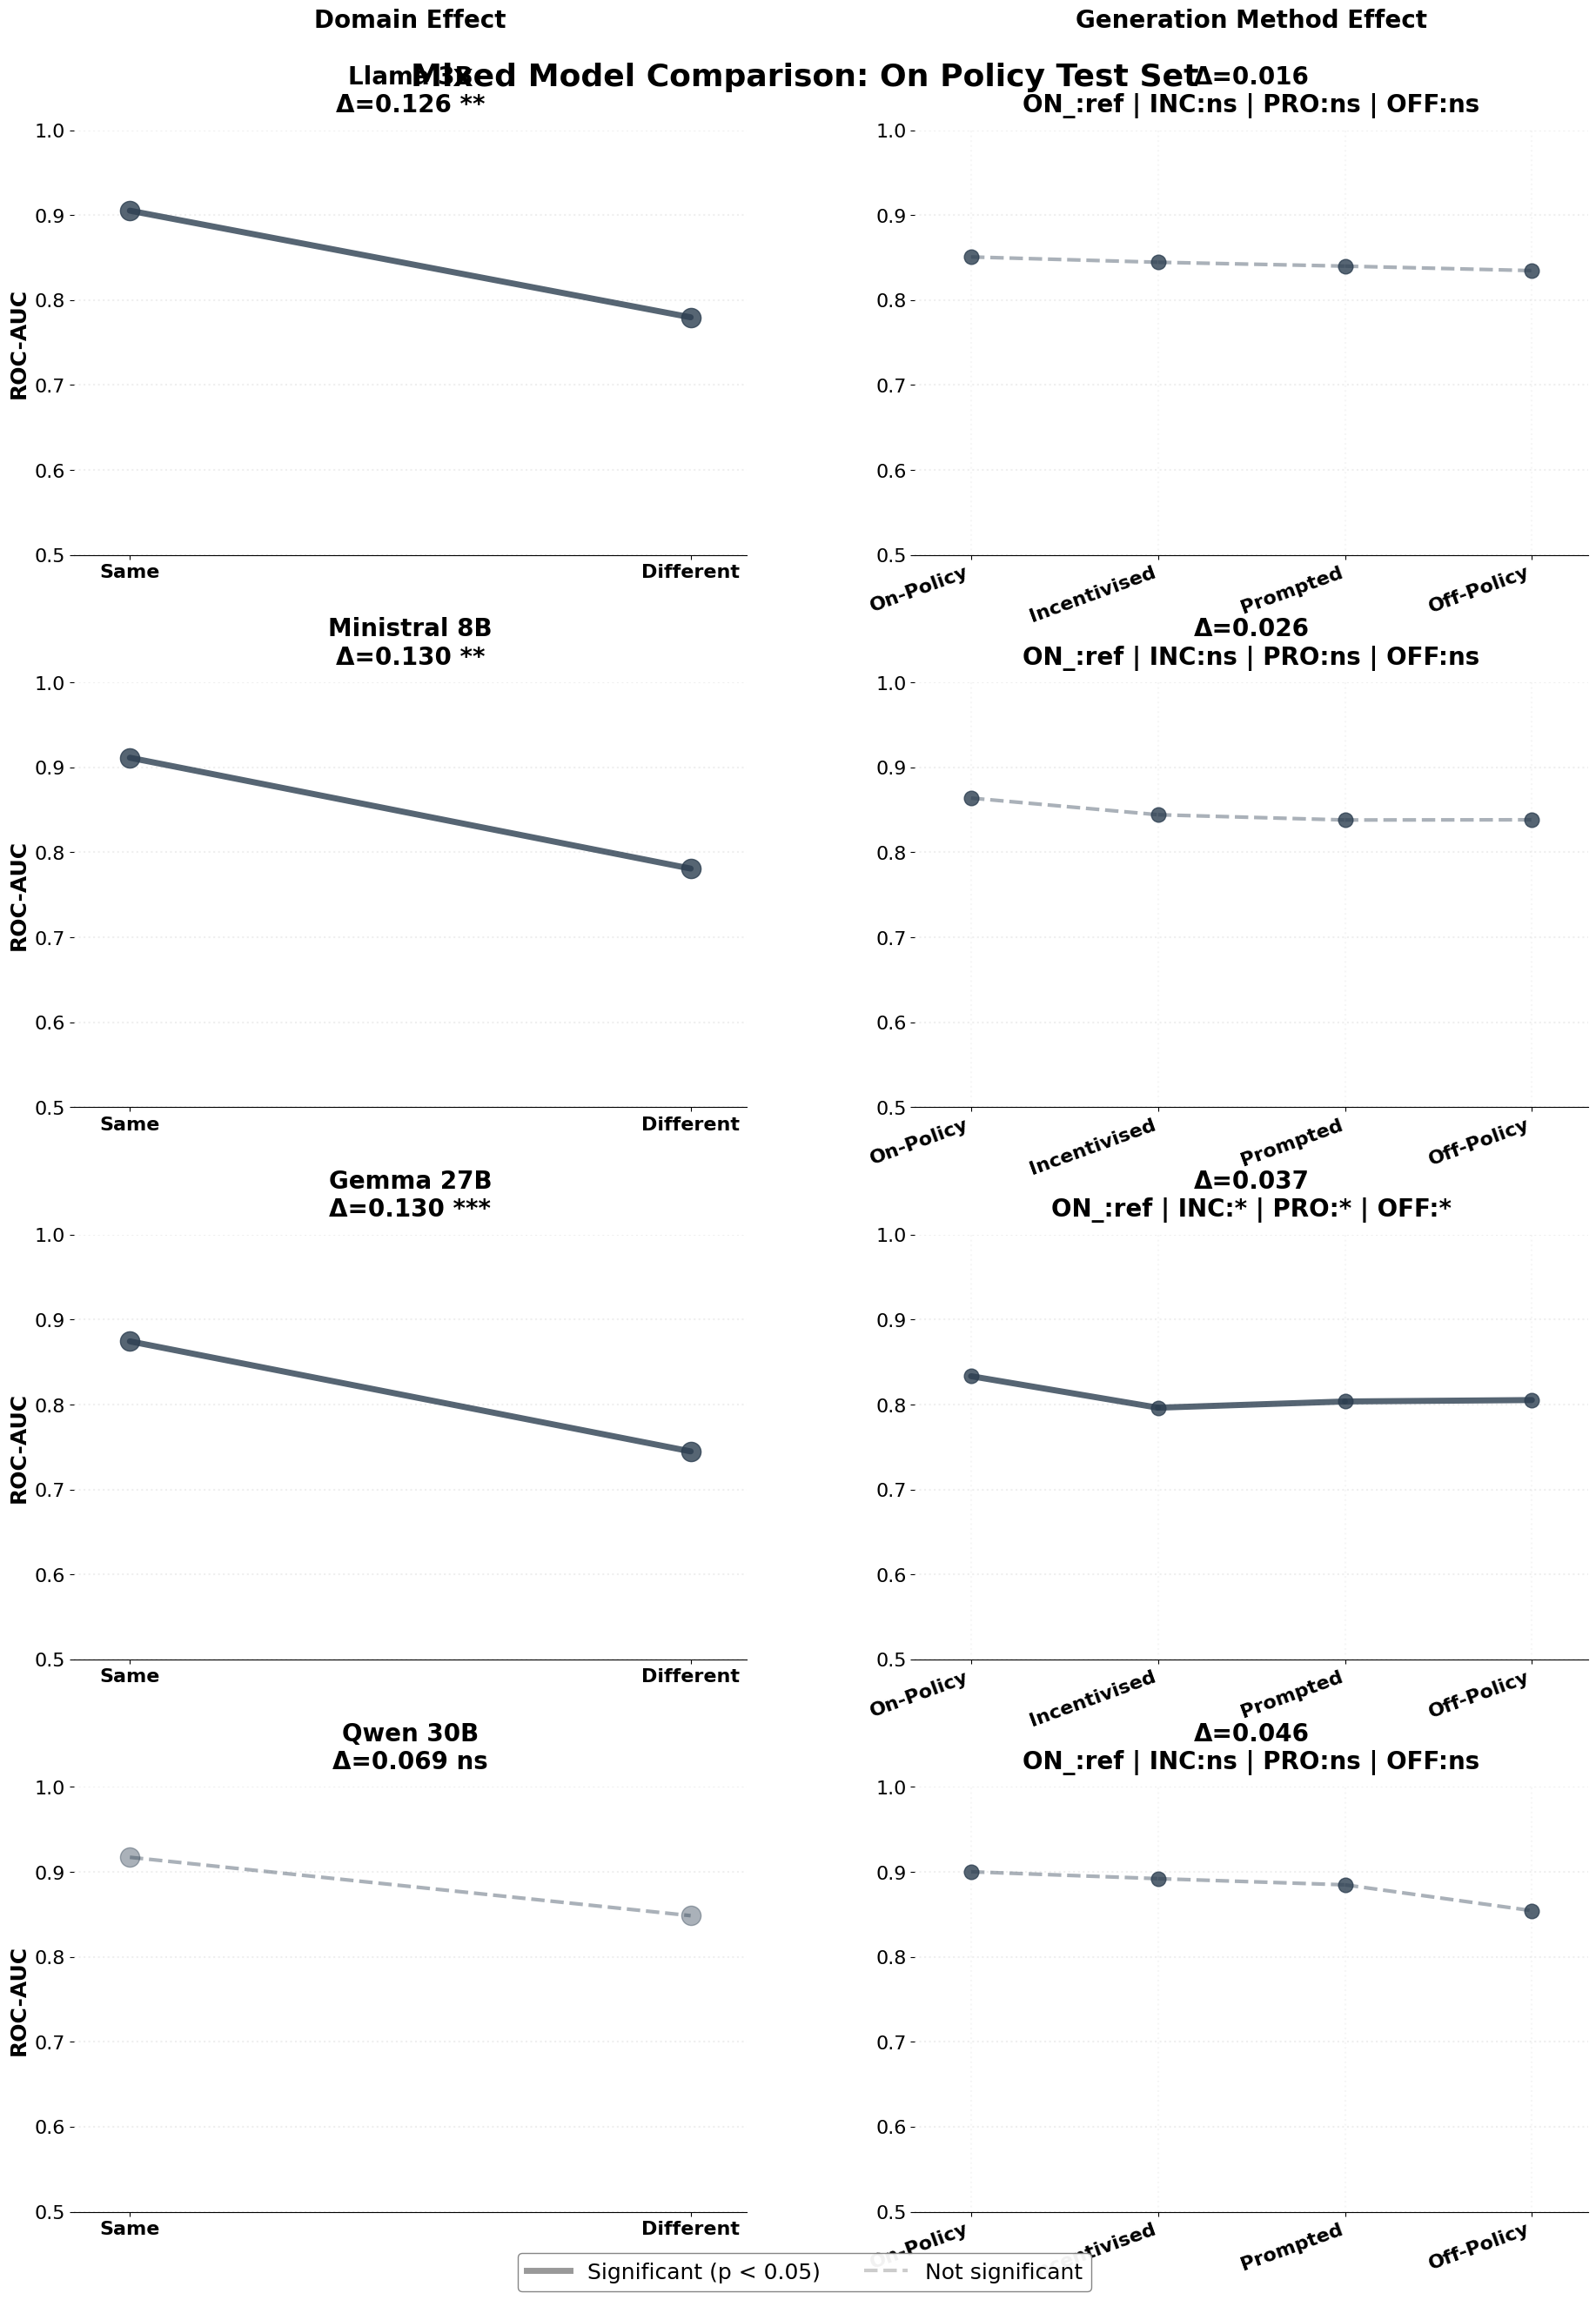

Figure saved to: /workspace/LASR-probe-gen/data/mixed_model_results/ols/on_policy/all_models_combined.pdf


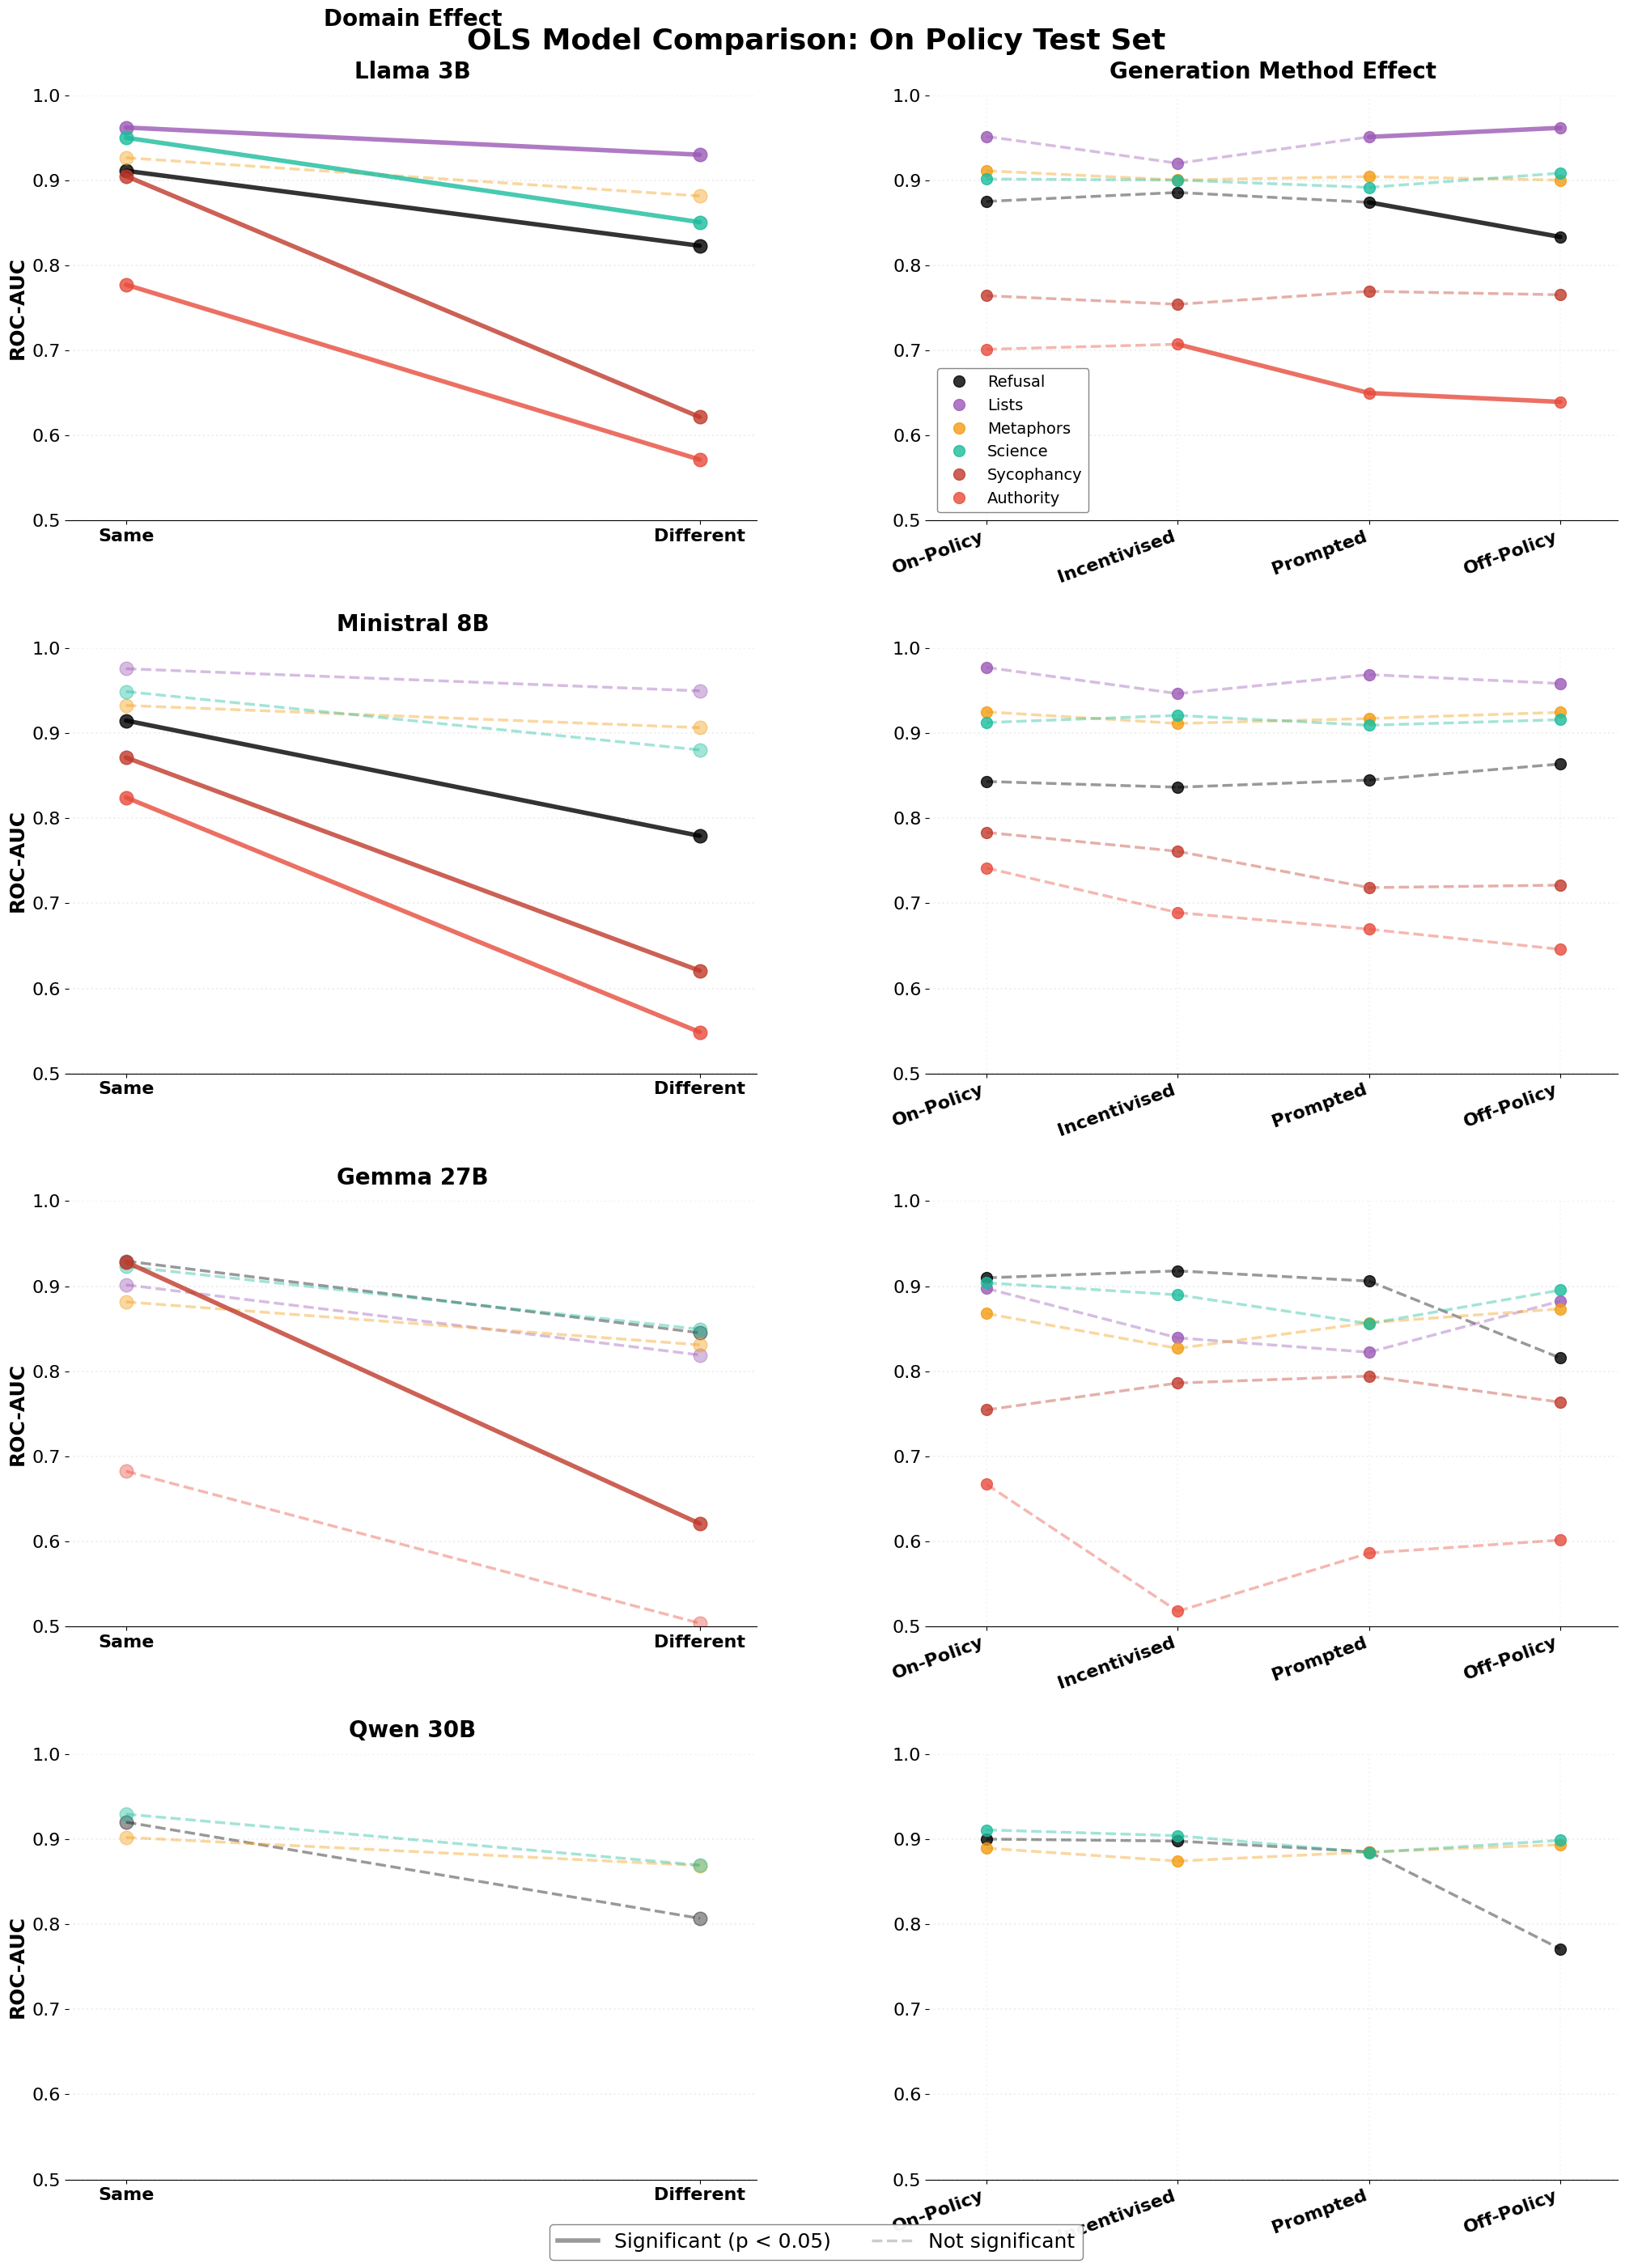


Generating combined graphs for test set: incentivised
Figure saved to: /workspace/LASR-probe-gen/data/mixed_model_results/mixed_model/incentivised/all_models_combined.pdf


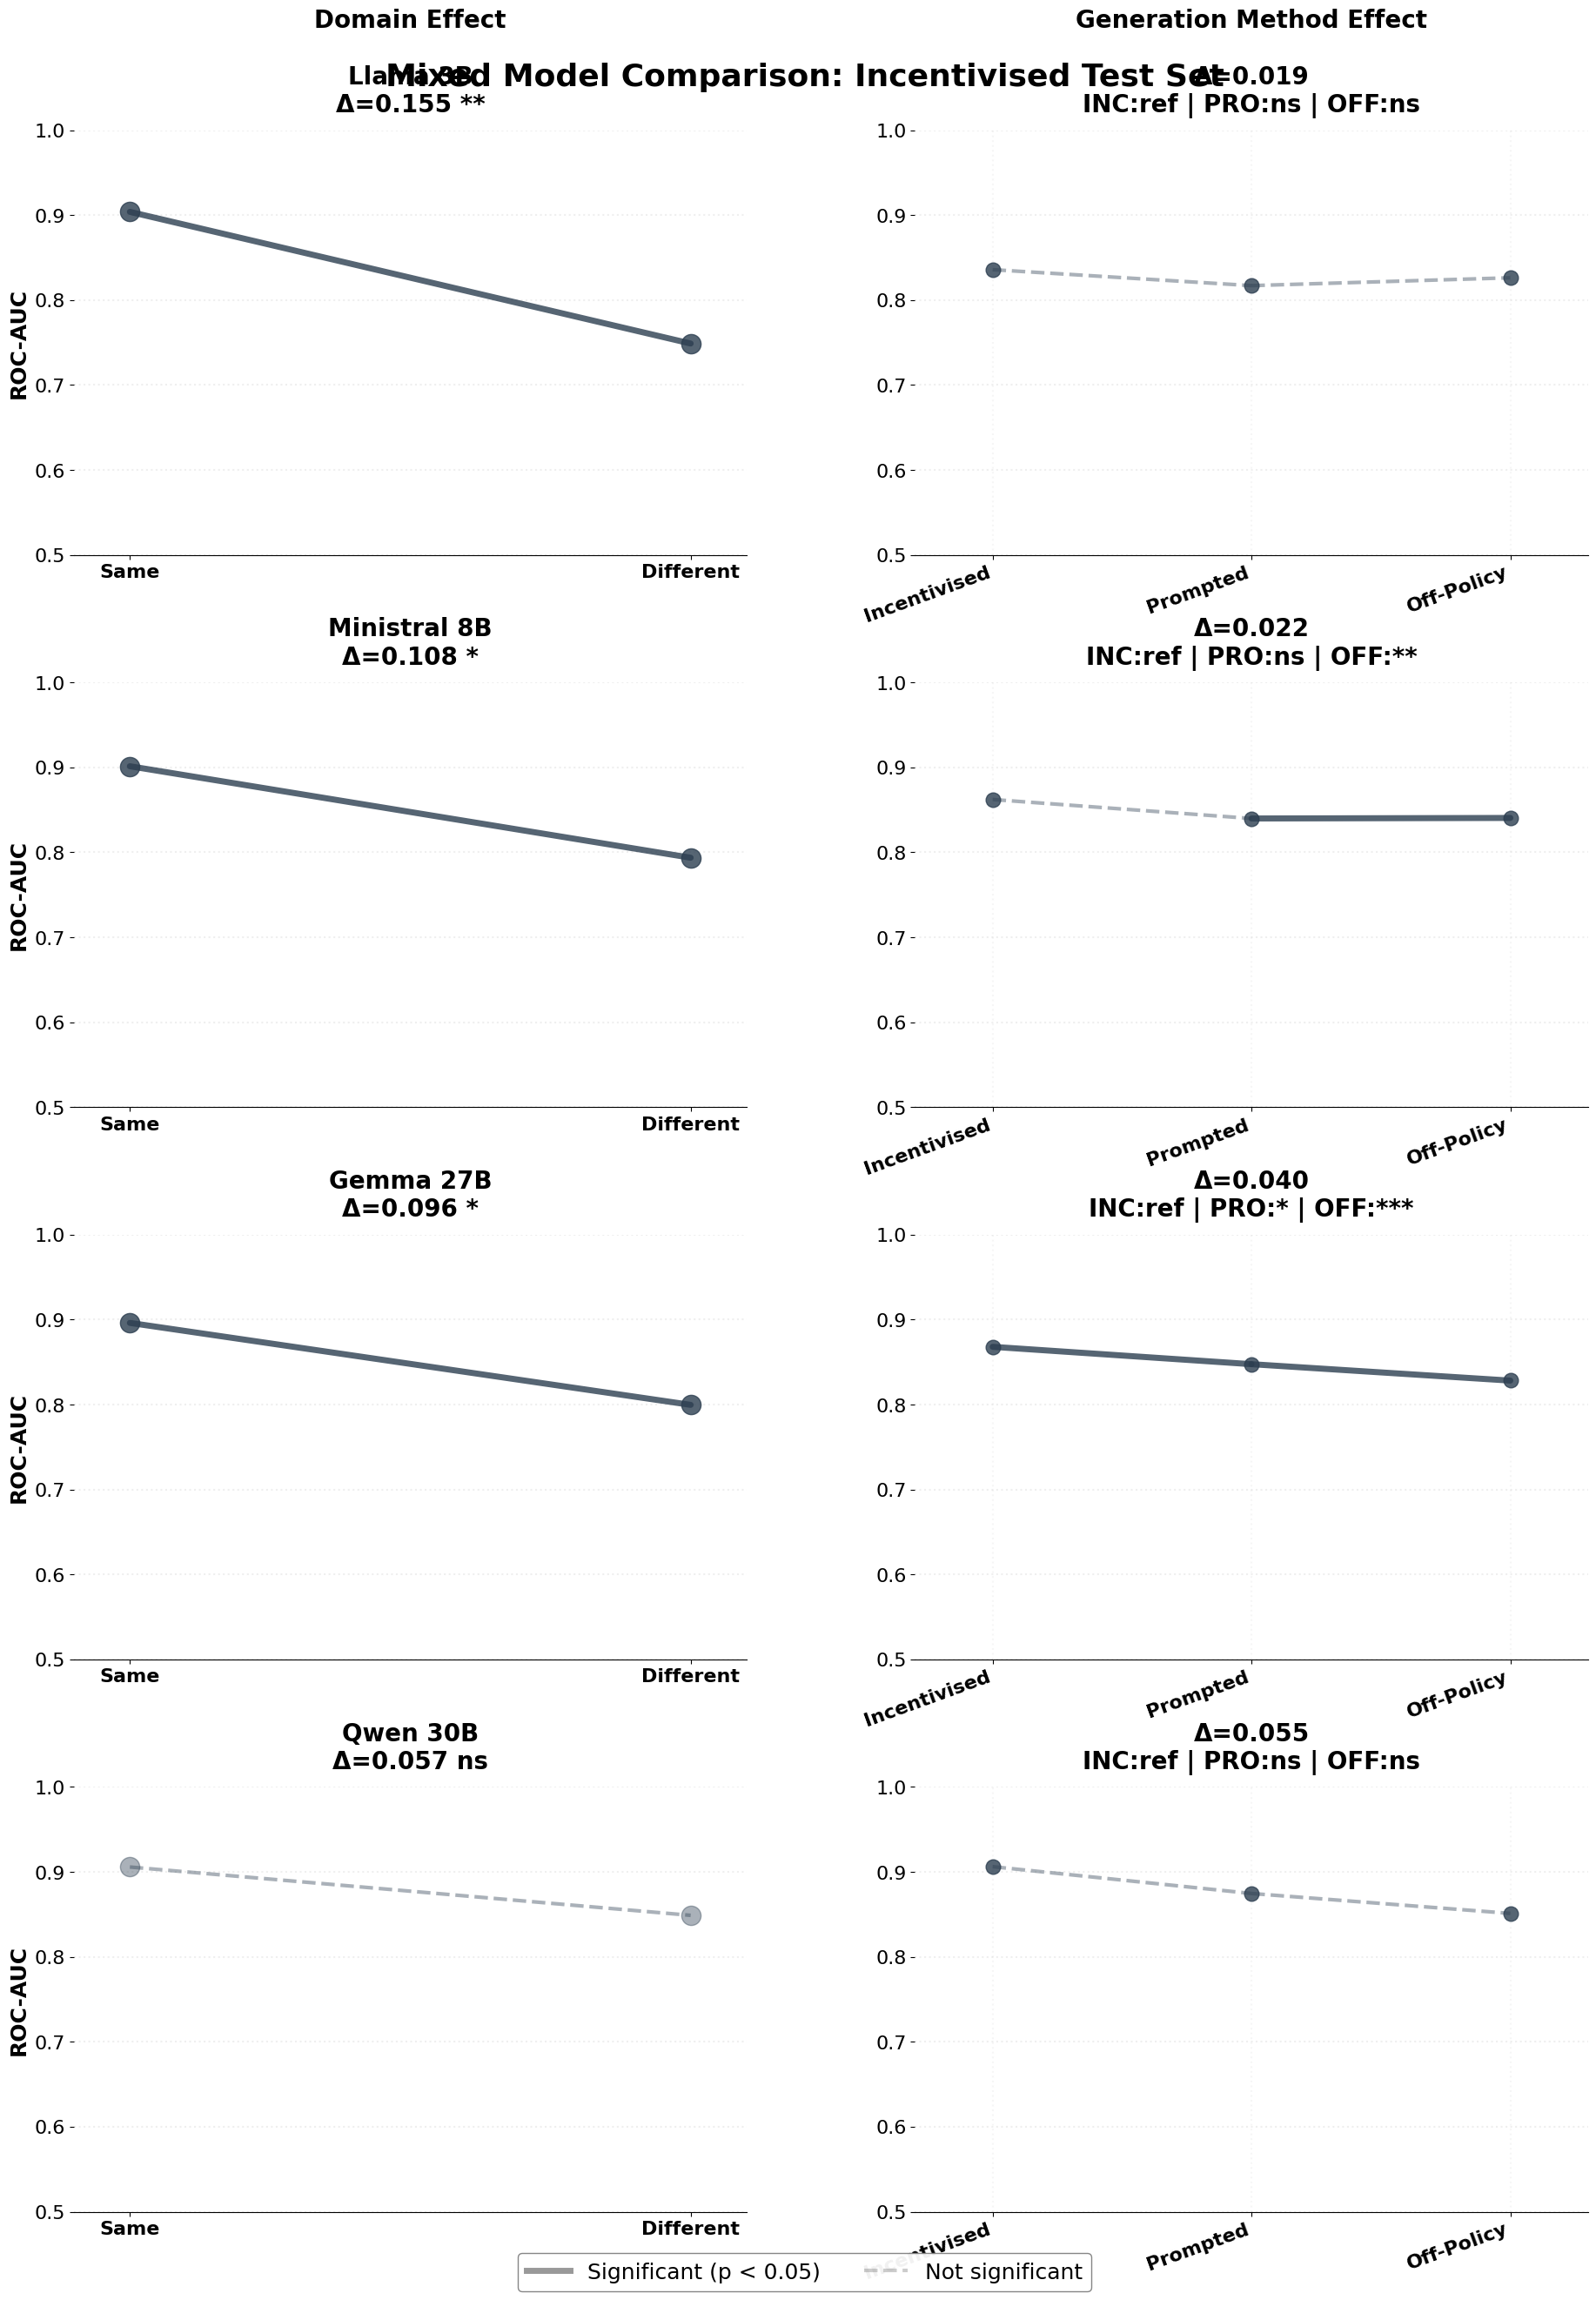

Figure saved to: /workspace/LASR-probe-gen/data/mixed_model_results/ols/incentivised/all_models_combined.pdf


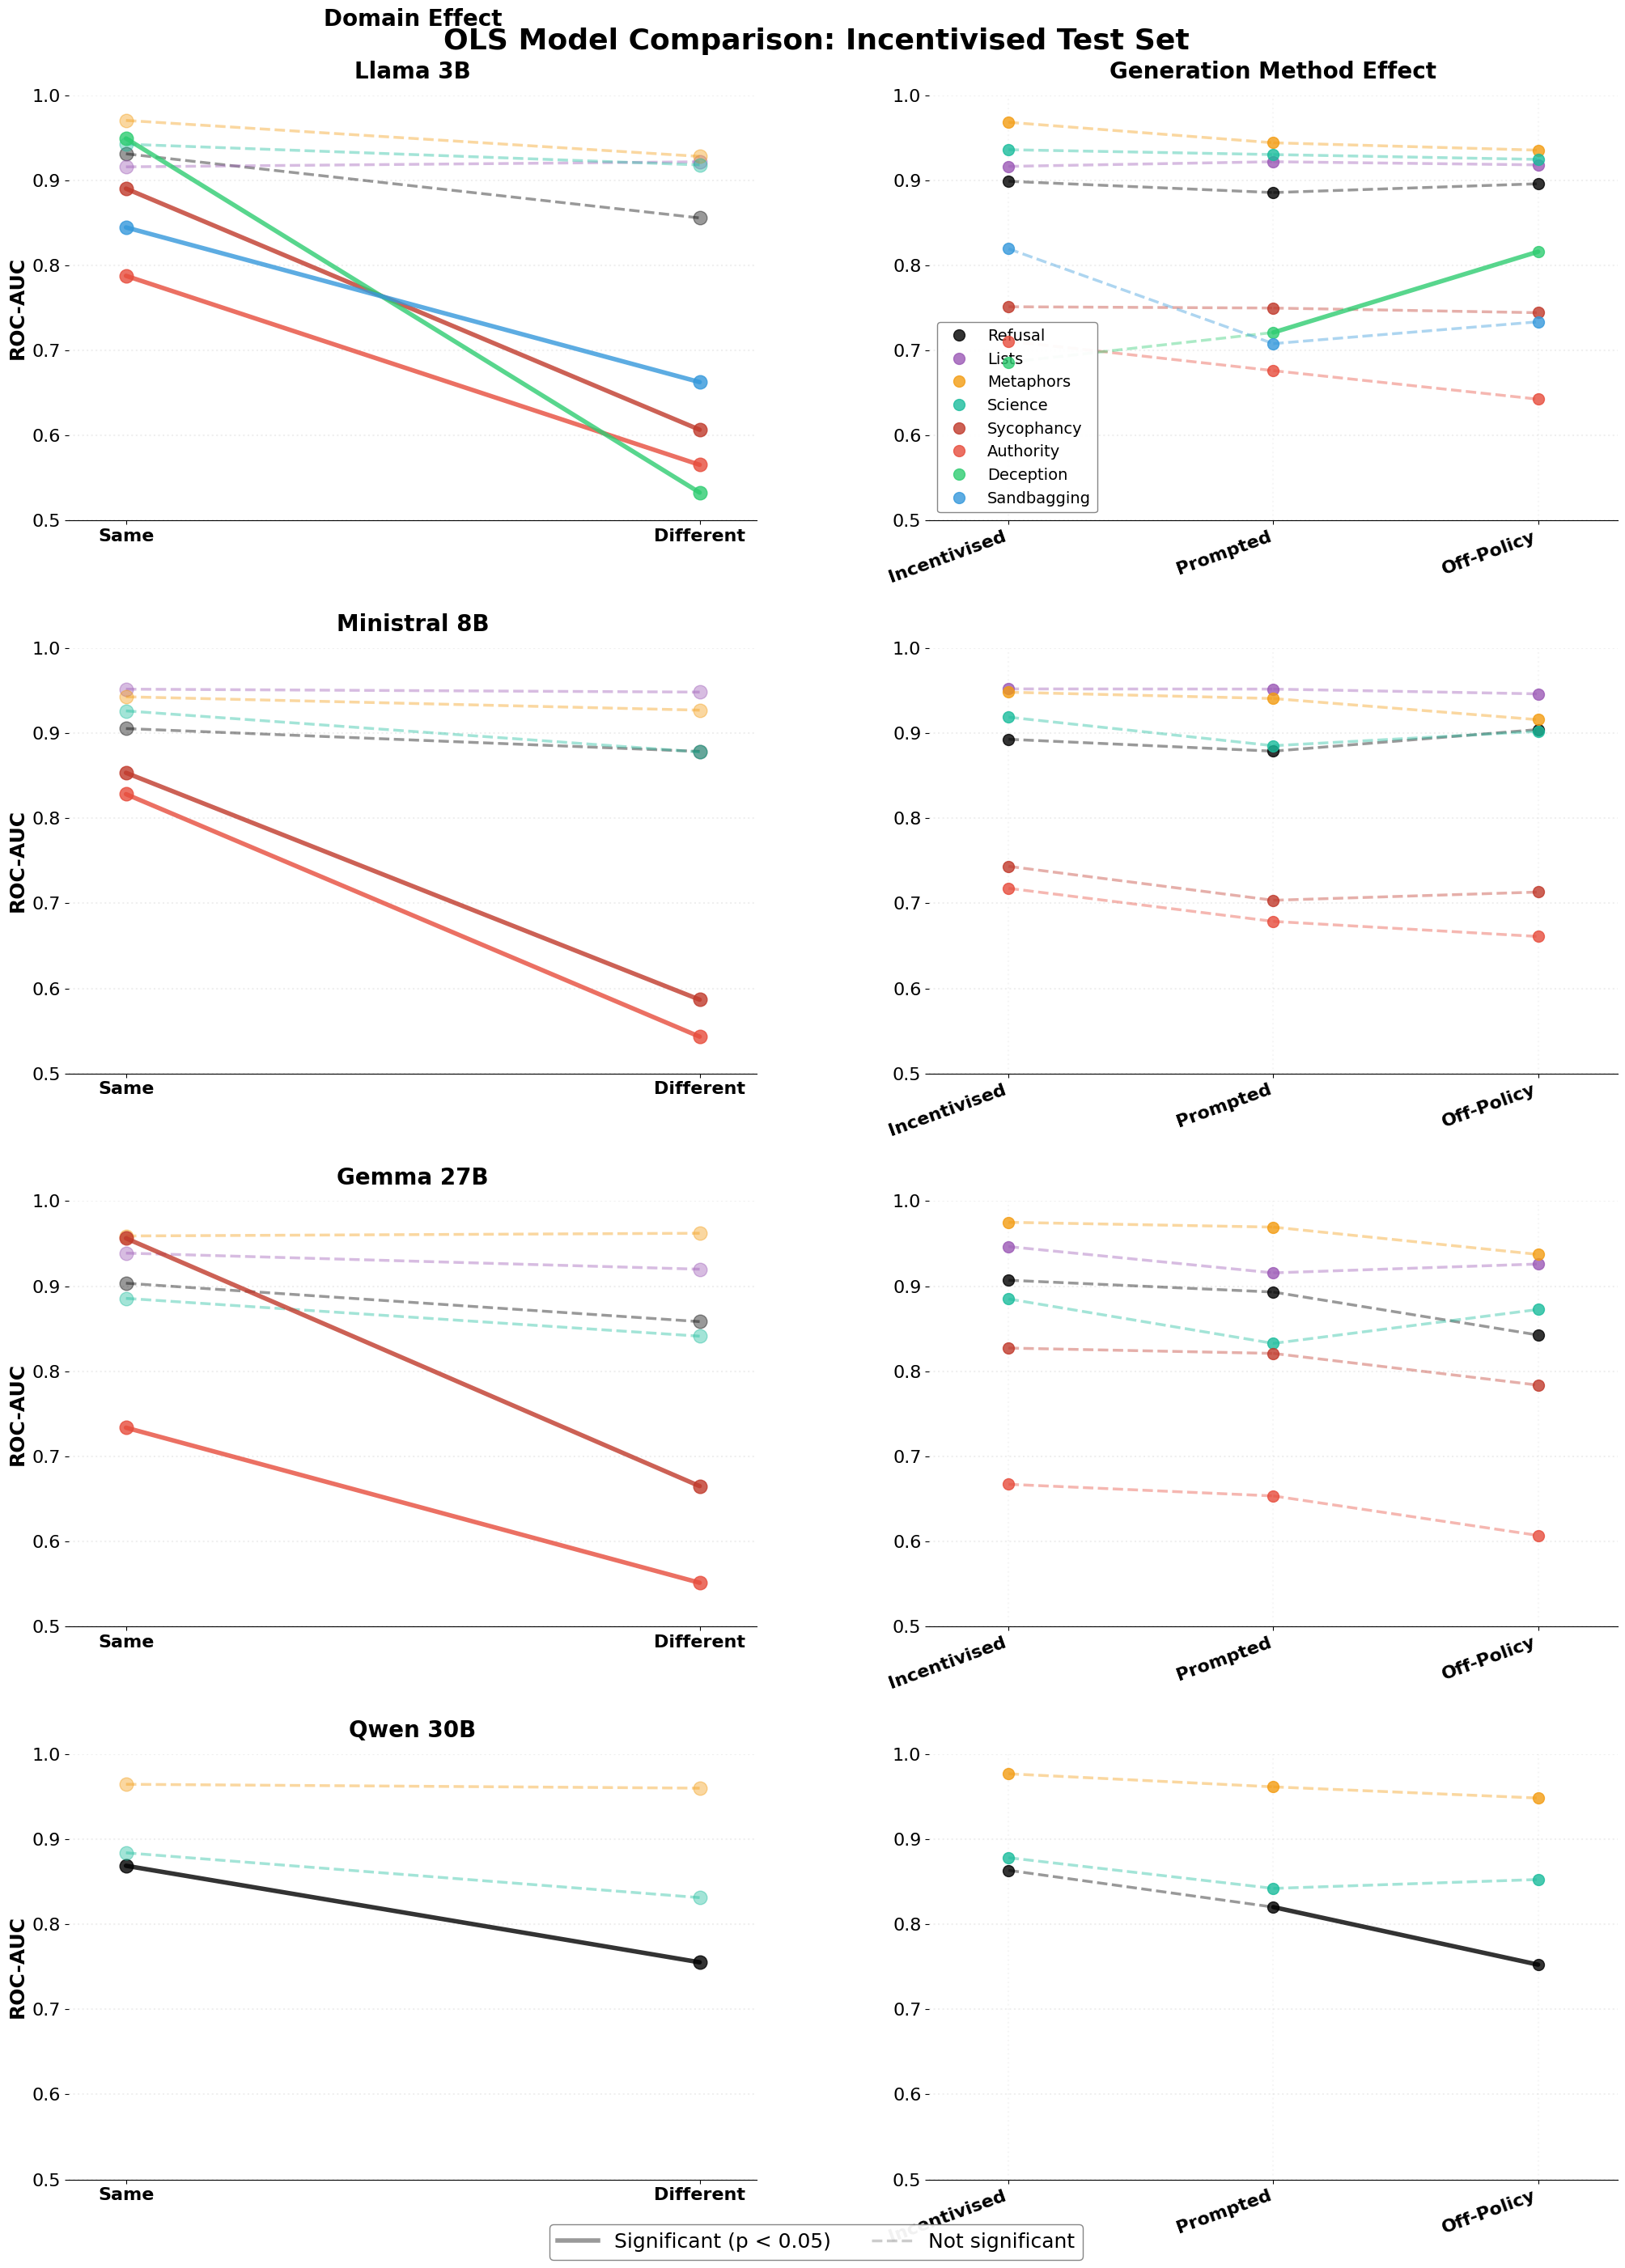


Combined comparison graphs generated!


In [40]:
def plot_all_models_ols_comparison(results_all_models, test_set, save_path=None):
    """
    Create a 4x2 grid showing both domain effect (left) and generation method effect (right)
    with behaviour-specific lines for all 4 models in one figure.
    """
    model_names = ['llama_3b', 'ministral_8b', 'gemma_27b', 'qwen_30b']
    
    behavior_colors = {
        'Authority': '#e74c3c', 'Sandbagging': '#3498db', 'Deception': '#2ecc71',
        'Lists': '#9b59b6', 'Metaphors': '#f39c12', 'Science': '#1abc9c',
        'Refusal': "#000000", 'Sycophancy': "#c0392b",
    }
    
    # Create 4x2 subplot grid
    fig = plt.figure(figsize=(22, 28))
    gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.25, 
                         left=0.08, right=0.95, top=0.96, bottom=0.04)
    
    for row_idx, model_name in enumerate(model_names):
        ax_domain = fig.add_subplot(gs[row_idx, 0])
        ax_method = fig.add_subplot(gs[row_idx, 1])
        
        if model_name not in results_all_models:
            for ax in [ax_domain, ax_method]:
                ax.text(0.5, 0.5, f'No data', ha='center', va='center', fontsize=18)
                ax.axis('off')
            continue
        
        model_data = results_all_models[model_name]
        model_result = load_mixed_model_result(model_name, 'ols', test_set)
        
        if model_result is None:
            for ax in [ax_domain, ax_method]:
                ax.text(0.5, 0.5, f'No model', ha='center', va='center', fontsize=18)
                ax.axis('off')
            continue
        
        pvalues = model_result.pvalues
        
        # ===== LEFT: DOMAIN EFFECT BY BEHAVIOUR =====
        for behav in model_data['behaviour'].unique():
            behav_data = model_data[model_data['behaviour'] == behav]
            behav_means = behav_data.groupby('train_domain', observed=False)['roc_auc'].mean()
            
            same_val = behav_means.loc['same']
            diff_val = behav_means.loc['different']
            penalty = same_val - diff_val
            
            color = behavior_colors.get(behav.capitalize(), '#2c3e50')
            
            # Get p-value for this behaviour
            domain_pval = pvalues.get('train_domain[T.different]', 1.0)
            if behav != model_data['behaviour'].cat.categories[0]:
                interaction_key = f'train_domain[T.different]:C(behaviour)[T.{behav}]'
                if interaction_key in pvalues:
                    domain_pval = pvalues[interaction_key]
            
            is_sig = domain_pval < 0.05
            
            ax_domain.plot([0, 1], [same_val, diff_val], 
                          linestyle='-' if is_sig else '--',
                          linewidth=4 if is_sig else 2.5,
                          marker='o', markersize=12, color=color, 
                          alpha=0.8 if is_sig else 0.4, 
                          solid_capstyle='round')
        
        ax_domain.set_xlim([-0.1, 1.1])
        ax_domain.set_ylim([0.5, 1.0])
        ax_domain.set_xticks([0, 1])
        ax_domain.set_xticklabels(['Same', 'Different'], fontsize=18, fontweight='bold')
        
        if row_idx == 0:
            ax_domain.set_title(f'Domain Effect\n\n{model_name.replace("_", " ").title()}', 
                               fontsize=20, fontweight='bold', pad=15)
        else:
            ax_domain.set_title(f'{model_name.replace("_", " ").title()}', 
                               fontsize=20, fontweight='bold', pad=15)
        
        ax_domain.set_ylabel('ROC-AUC', fontsize=18, fontweight='bold')
        ax_domain.tick_params(axis='both', labelsize=16)
        ax_domain.grid(axis='y', alpha=0.2, linestyle=':', linewidth=1.5)
        ax_domain.spines['top'].set_visible(False)
        ax_domain.spines['right'].set_visible(False)
        ax_domain.spines['left'].set_visible(False)
        
        # ===== RIGHT: GENERATION METHOD EFFECT BY BEHAVIOUR =====
        preferred_order = ['on_policy', 'incentivised', 'prompted', 'off_policy']
        generation_col = 'train_generation_method'
        methods_in_data = set(model_data[generation_col].unique())
        available_methods = [m for m in preferred_order if m in methods_in_data]
        
        x_positions = list(range(len(available_methods)))
        
        for behav in model_data['behaviour'].unique():
            behav_data = model_data[model_data['behaviour'] == behav]
            method_means = behav_data.groupby(generation_col, observed=False)['roc_auc'].mean()
            
            values = [method_means.loc[method] for method in available_methods]
            color = behavior_colors.get(behav.capitalize(), '#2c3e50')
            
            # Plot segments
            for i in range(len(x_positions) - 1):
                method_end = available_methods[i + 1]
                
                # Get p-value for this method and behaviour
                method_pval = pvalues.get(f'train_generation_method[T.{method_end}]', 1.0)
                if behav != model_data['behaviour'].cat.categories[0]:
                    interaction_key = f'train_generation_method[T.{method_end}]:C(behaviour)[T.{behav}]'
                    if interaction_key in pvalues:
                        method_pval = pvalues[interaction_key]
                
                is_sig = method_pval < 0.05
                
                ax_method.plot([x_positions[i], x_positions[i+1]], [values[i], values[i+1]], 
                              linestyle='-' if is_sig else '--',
                              linewidth=4 if is_sig else 2.5,
                              color=color, alpha=0.8 if is_sig else 0.4, 
                              solid_capstyle='round')
            
            # Draw points on top
            ax_method.plot(x_positions, values, marker='o', markersize=10, 
                          color=color, alpha=0.8, linestyle='', zorder=10,
                          label=behav.capitalize() if row_idx == 0 else None)
        
        ax_method.set_xlim([-0.3, len(available_methods) - 0.7])
        ax_method.set_ylim([0.5, 1.0])
        ax_method.set_xticks(x_positions)
        
        method_labels = [m.replace('_', '-').title() for m in available_methods]
        ax_method.set_xticklabels(method_labels, fontsize=16, fontweight='bold', 
                                  rotation=20, ha='right')
        
        if row_idx == 0:
            ax_method.set_title(f'Generation Method Effect', 
                               fontsize=20, fontweight='bold', pad=15)
            ax_method.legend(loc='lower left', fontsize=14, framealpha=0.95, 
                           edgecolor='gray', ncol=1)
        
        ax_method.tick_params(axis='both', labelsize=16)
        ax_method.grid(axis='y', alpha=0.2, linestyle=':', linewidth=1.5)
        ax_method.grid(axis='x', alpha=0.1, linestyle=':', linewidth=1.5)
        ax_method.spines['top'].set_visible(False)
        ax_method.spines['right'].set_visible(False)
        ax_method.spines['left'].set_visible(False)
    
    plt.suptitle(f'OLS Model Comparison: {test_set.replace("_", " ").title()} Test Set', 
                fontsize=26, fontweight='bold', y=0.99)
    
    # Legend
    style_elements = [
        Line2D([0], [0], color='gray', linewidth=4, linestyle='-', alpha=0.8, 
               label='Significant (p < 0.05)'),
        Line2D([0], [0], color='gray', linewidth=2.5, linestyle='--', alpha=0.4, 
               label='Not significant')
    ]
    fig.legend(handles=style_elements, loc='lower center', bbox_to_anchor=(0.5, 0.0),
              fontsize=18, ncol=2, framealpha=0.95, edgecolor='gray')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig


# Generate the combined comparison graphs
test_sets = ['on_policy', 'incentivised']

for test_set in test_sets:
    print(f"\n{'='*60}")
    print(f"Generating combined graphs for test set: {test_set}")
    print(f"{'='*60}")
    
    # Filter data for each model
    filtered_data = {}
    for model_name in ['llama_3b', 'ministral_8b', 'gemma_27b', 'qwen_30b']:
        if model_name in results_all_models:
            if test_set == 'on_policy':
                filtered = results_all_models[model_name][
                    (results_all_models[model_name]['test_generation_method'] == 'on_policy') & 
                    (results_all_models[model_name]['behaviour'] != 'deception') & 
                    (results_all_models[model_name]['behaviour'] != 'sandbagging')
                ].copy()
            else:
                filtered = results_all_models[model_name][
                    (results_all_models[model_name]['test_generation_method'] == 'incentivised') & 
                    (results_all_models[model_name]['train_generation_method'] != 'on_policy')
                ].copy()
            
            # Add generation_method column and set categorical ordering
            filtered['generation_method'] = filtered['train_generation_method']
            
            if test_set == 'on_policy':
                filtered['generation_method'] = pd.Categorical(
                    filtered['generation_method'],
                    categories=['on_policy', 'incentivised', 'off_policy', 'prompted'],
                    ordered=False
                )
            else:
                filtered['generation_method'] = pd.Categorical(
                    filtered['generation_method'],
                    categories=['incentivised', 'off_policy', 'prompted'],
                    ordered=False
                )
            
            filtered['train_domain'] = pd.Categorical(
                filtered['train_domain'],
                categories=['same', 'different'],
                ordered=False
            )
            
            filtered_data[model_name] = filtered
    
    # Generate combined mixed model graph
    save_path = Path(DATA_DIR) / 'mixed_model_results' / 'mixed_model' / test_set / 'all_models_combined.pdf'
    fig = plot_all_models_mixed_comparison(filtered_data, test_set, str(save_path))
    plt.show()
    plt.close()
    
    # Generate combined OLS graph (now with BOTH effects)
    save_path = Path(DATA_DIR) / 'mixed_model_results' / 'ols' / test_set / 'all_models_combined.pdf'
    fig = plot_all_models_ols_comparison(filtered_data, test_set, str(save_path))
    plt.show()
    plt.close()

print("\n" + "="*60)
print("Combined comparison graphs generated!")
print("="*60)